In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from coffea import util
from coffea.processor import accumulate
import os
import re
import pandas as pd
import hist
import sys
import matplotlib as mpl
sys.path.append("../../analysisTools/")
import plotTools as ptools
import utils
import mplhep as hep
import json

In [2]:
def get_stuff(hcname,hbname,CUT):
    hcs = ptools.histContainer(f"coffea/{hcname}")
    hcb = ptools.histContainer(f"coffea/{hbname}",bkg=True)
    dfs = utils.get_dict_fromCutflow(hcs.load('cutflow'))
    dfs['legend'] = dfs.apply(ptools.make_label,axis=1)
    selected_signals = ["sig_2018_Mchi-10p5_dMchi-1p0_ctau-1",
                        "sig_2018_Mchi-11p0_dMchi-2p0_ctau-100",
                        "sig_2018_Mchi-52p5_dMchi-5p0_ctau-10",
                        "sig_2018_Mchi-77p0_dMchi-14p0_ctau-100"]
    selected_labels = [dfs[dfs.name==s].legend.item() for s in selected_signals]

    cfs = hcs.load('cutflow_cts')
    cfb = hcb.load('cutflow_cts')
    cutDesc = hcs.load('cutDesc')

    lumi_scale = (137.63/59.83)

    nbkg_tot = 0
    for k in cfb.keys():
        nbkg_tot += cfb[k][CUT]
    nbkg_tot = nbkg_tot*lumi_scale
    
    sig_samples = dfs.name.to_list()
    sig_tots = {}
    
    for samp in sig_samples:
        nsig_tot = cfs[samp][CUT]
        nsig_tot = nsig_tot*lumi_scale
        sig_tots[samp] = nsig_tot
        
    print("NBKG = ",nbkg_tot)
    
    return hcs, hcb, dfs, cfs, cfb, sig_tots, nbkg_tot

In [3]:
# make combine cards
def make_cards(sig_tots,bkg_tot,dfs,outDir,CUT,evtScale=300):
    base="/uscms/home/sbrightt/nobackup/iDM/iDMe_analysis/CMSSW_11_3_4/src/iDMe_limits/"
    sig_samples = dfs.name.to_list()
    for samp in sig_samples:
        dfc = dfs[dfs.name==samp]
        delta = dfc.delta[0]
        m1 = dfc.m1[0]
        ct = dfc.ctau[0]
        name = f"card_delta{int(100*delta)}_m{int(m1)}_ct{int(ct)}.txt"
        
        
        with open(base+"card.txt","r") as f:
            template = f.read()
        nsig_tot = sig_tots[samp]
        nsig_write = nsig_tot if nsig_tot < evtScale else nsig_tot/evtScale
        nbkg_write = bkg_tot
        data = template.replace("NSIG",f"{nsig_write:.6f}")
        data = data.replace("NBKG",f"{nbkg_write:.6f}")
        data = data.replace("NOBS",f"{nbkg_write:.6f}")
        with open(f"{outDir}/{name}","w") as f:
            f.write(data)

In [4]:
noms_all = {}
robs_all = {}
m1s_all = {}

signal_json = "../../configs/sample_configs/skimmed_signal/skimmed_signal_2018_v11_miniAOD_aEM_rdfSkim_MET200_nJetsG0.json"
with open(signal_json,"r") as fin:
    js = json.load(fin)
    
xs = {"name":[],"m1":[],"delta":[],"ctau":[],"xs":[]}
for sig_pt in js:
    mchi = sig_pt["Mchi"]
    dm = sig_pt['dMchi']
    m1 = mchi-dm/2
    delta = dm/m1
    xs['m1'].append(m1)
    xs['delta'].append(delta)
    xs['ctau'].append(sig_pt['ctau'])
    xs['xs'].append(sig_pt['xsec']/1000)
    xs['name'].append(sig_pt['name'])
xs = pd.DataFrame(xs)

# With Njets All

NBKG =  22.799505554157278


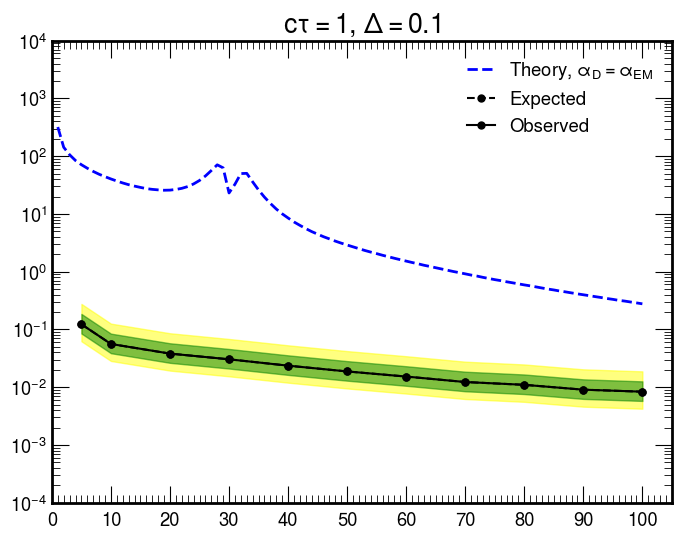

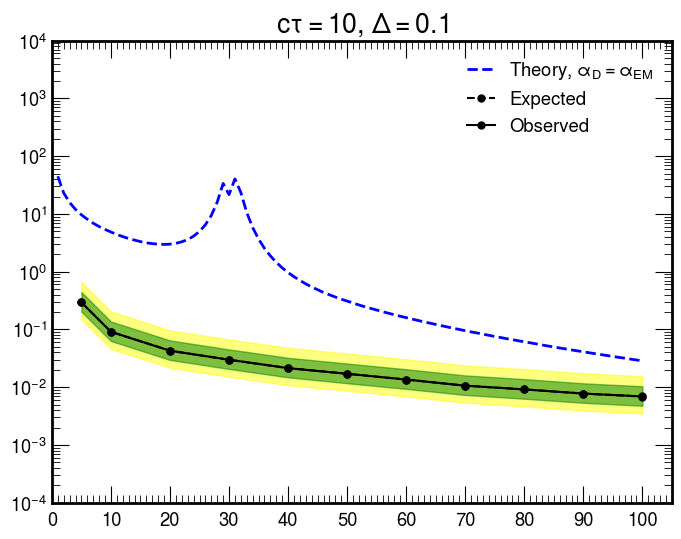

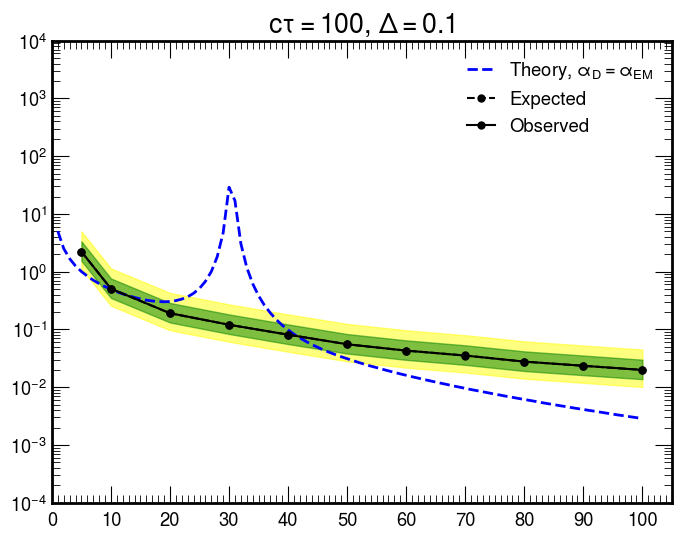

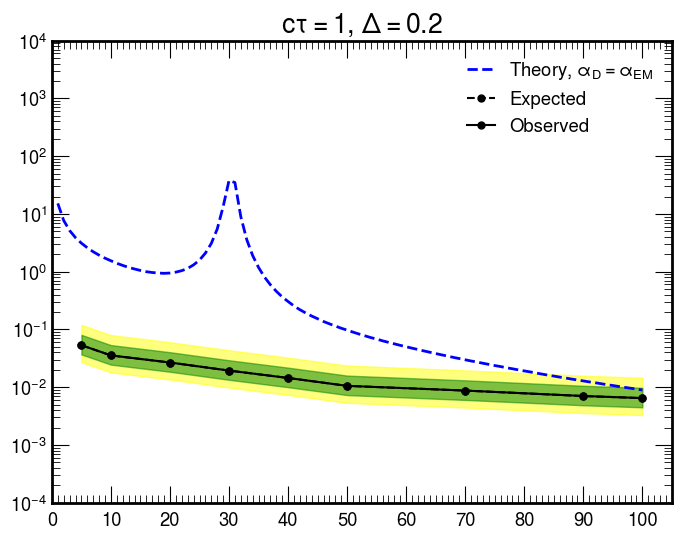

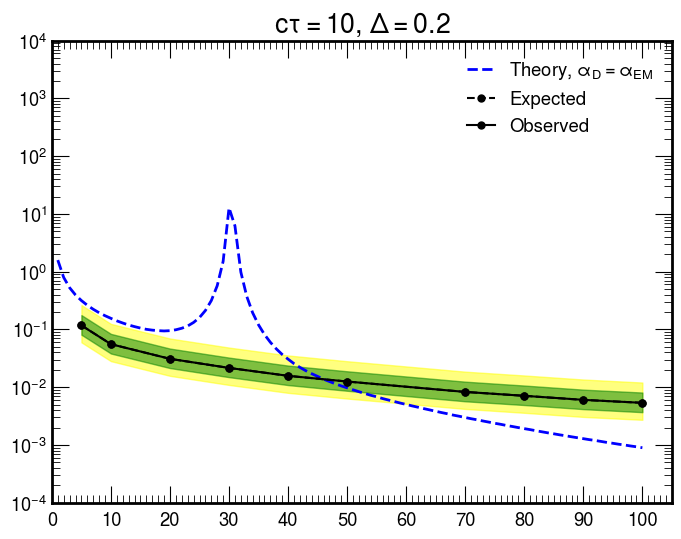

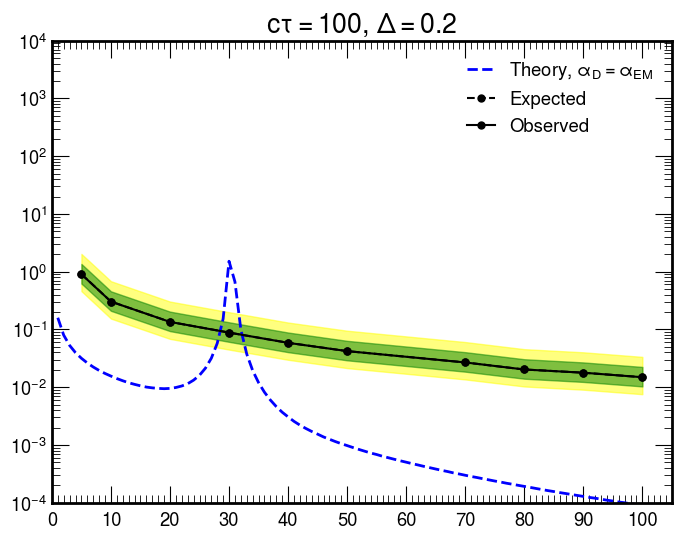

In [18]:
import os
import uproot
import pandas as pd
hcname = "skimmed_signal_2018_v11_miniAOD_aEM_rdfSkim_MET200_nJetsG0.coffea"
hbname = "skimmed_bkg_2018_v9_miniAOD_rdfSkim_MET200_nJetsG0.coffea"
base="/uscms/home/sbrightt/nobackup/iDM/iDMe_analysis/CMSSW_11_3_4/src/iDMe_limits/BDT_latest/NJetsAll/"
hcs, hcb, dfs, cfs, cfb, sig_tots, nbkg_tot = get_stuff(hcname,hbname,"cut9")

xs = pd.read_csv('/uscms_data/d3/sbrightt/iDMe/signal_xsec/condor/signal_xsec_table.csv')
xs = xs[xs.alphaD=="aEM"]
xs = xs[xs['mA/m1'] == 3]

root_files = [f for f in os.listdir(base) if '.root' in f]
m1s = []
cts = []
deltas = []
rs = []
rs_plus1 = []
rs_minus1 = []
rs_plus2 = []
rs_minus2 = []
robs = []
xsecs = []
for rf in root_files:
    point = rf.split('.')[1]
    delta,m1,ct = point.split("_")
    if delta == 0.4:
        continue
    delta = float(delta[5:])/100
    m1 = float(m1[1:])
    ct = float(ct[2:])
    with uproot.open(base+rf)['limit'] as rootf:
        lims = rootf['limit'].array().to_numpy()
    if len(lims) < 5:
        continue
    xsecs.append(xs[(xs.m1==m1)&(xs.delta==delta)&(xs.ctau==ct)]['xs'].iloc[0])
    deltas.append(delta)
    m1s.append(m1)
    cts.append(ct)
    rs_minus2.append(lims[0])
    rs_minus1.append(lims[1])
    rs.append(lims[2])
    rs_plus1.append(lims[3])
    rs_plus2.append(lims[4])
    robs.append(lims[5])
lims = pd.DataFrame({
    "m1":m1s,
    "ct":cts,
    "delta":deltas,
    "r":rs,
    "rp1":rs_plus1,
    "rm1":rs_minus1,
    "rp2":rs_plus2,
    "rm2":rs_minus2,
    "robs":robs,
    "xsec":xsecs
})

noms_NJetAll = {}
robs_NJetAll = {}
m1s_NJetAll = {}

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

deltas = [0.1,0.2]
all_ctaus = [1,10,100]
for d in deltas:
    for i,ct in enumerate(all_ctaus):
        plt.figure(figsize=(8,6))
        mass1s = sorted(list(set(lims[(lims.delta==d)&(lims.ct==ct)].m1.array.to_numpy())))
        theory_xsec = xs[(xs.delta==d)&(xs.ctau==ct)]["xs"].array.to_numpy()
        theory_m1 = xs[(xs.delta==d)&(xs.ctau==ct)]["m1"].array.to_numpy()
        srt = np.argsort(theory_m1)
        theory_m1 = theory_m1[srt]
        theory_xsec = theory_xsec[srt]
        plt.title(r"$c \tau = {0}$, $\Delta = {1}$".format(ct,d))
        plt.plot(theory_m1,theory_xsec,color="blue",linestyle="--",linewidth=2,label=r"Theory, $\alpha_D = \alpha_\mathrm{EM}$")
        
        noms = []
        p1s = []
        m1s = []
        p2s = []
        m2s = []
        obs = []
        for m1 in mass1s:
            scale = 1.0
            sig_pt = dfs[(dfs.delta==d)&(dfs.ctau==ct)&(dfs.m1==m1)].name[0]
            if sig_tots[sig_pt] >= 300:
                scale = 1.0/(300*(sig_tots[sig_pt]/300))
            robs = lims[(lims.delta==d)&(lims.ct==ct)&(lims.m1==m1)].robs.iloc[0]
            r = lims[(lims.delta==d)&(lims.ct==ct)&(lims.m1==m1)].r.iloc[0]
            rm1 = lims[(lims.delta==d)&(lims.ct==ct)&(lims.m1==m1)].rm1.iloc[0]
            rp1 = lims[(lims.delta==d)&(lims.ct==ct)&(lims.m1==m1)].rp1.iloc[0]
            rm2 = lims[(lims.delta==d)&(lims.ct==ct)&(lims.m1==m1)].rm2.iloc[0]
            rp2 = lims[(lims.delta==d)&(lims.ct==ct)&(lims.m1==m1)].rp2.iloc[0]
            xsec = lims[(lims.delta==d)&(lims.ct==ct)&(lims.m1==m1)].xsec.iloc[0]
            obs.append(scale*robs*xsec)
            noms.append(scale*r*xsec)
            m1s.append(scale*rm1*xsec)
            p1s.append(scale*rp1*xsec)
            m2s.append(scale*rm2*xsec)
            p2s.append(scale*rp2*xsec)
        plt.fill_between(mass1s,m2s,p2s,color="yellow",alpha=0.5)
        plt.fill_between(mass1s,m1s,p1s,color="green",alpha=0.5)
        plt.plot(mass1s,noms,color="black",marker=".",markersize=10,label="Expected",linestyle='--')
        plt.plot(mass1s,obs,color="black",marker=".",markersize=10,label="Observed",linestyle='-')
        
        noms_NJetAll[f"delta{d}_ct{ct}"] = noms
        robs_NJetAll[f"delta{d}_ct{ct}"] = obs
        m1s_NJetAll[f"delta{d}_ct{ct}"] = mass1s
        
        plt.legend()
        plt.ylim([1e-4,1e4])
        plt.yscale('log')
        plt.xlim([0,105])
        ax = plt.gca()
        ax.xaxis.set_major_locator(MultipleLocator(10))
        ax.xaxis.set_major_formatter('{x:.0f}')
        ax.xaxis.set_minor_locator(MultipleLocator(1))
        #plt.savefig(f"plots/expected_lims/delta{d}_ct{ct}.pdf")

# With Njets < 4

NBKG =  7.705600055624265


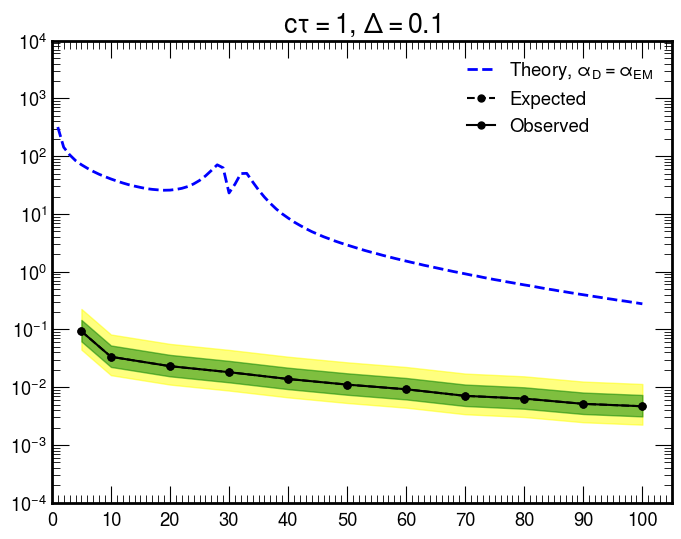

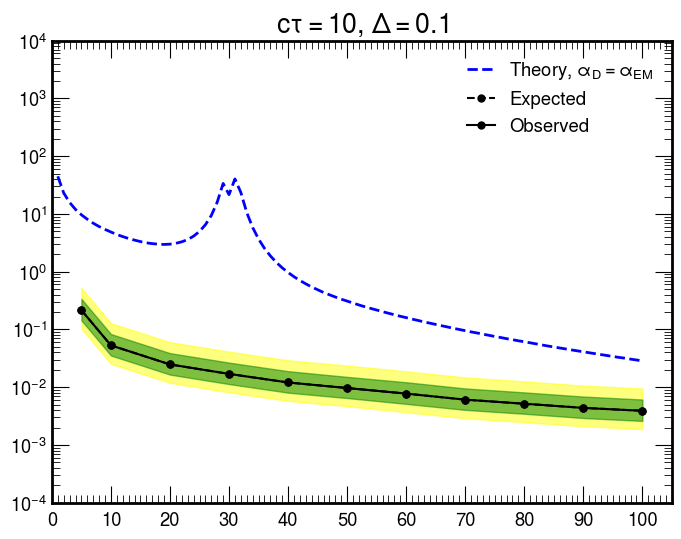

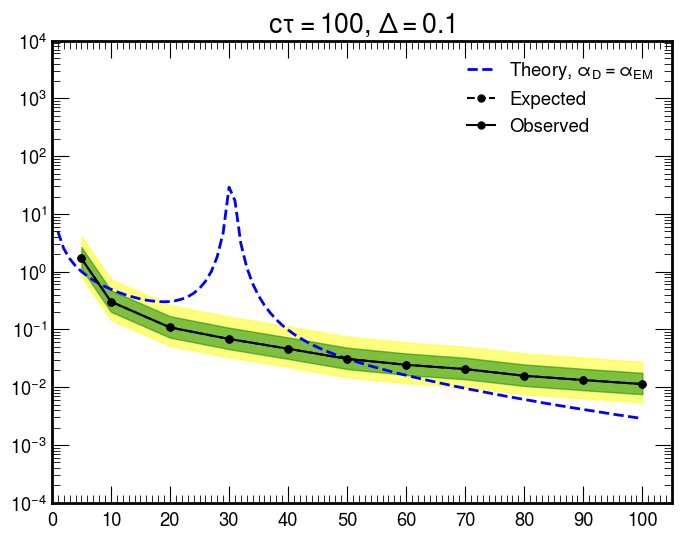

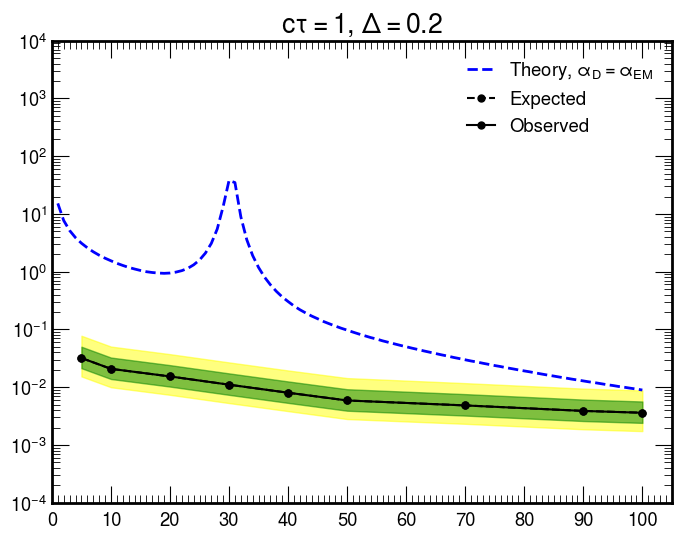

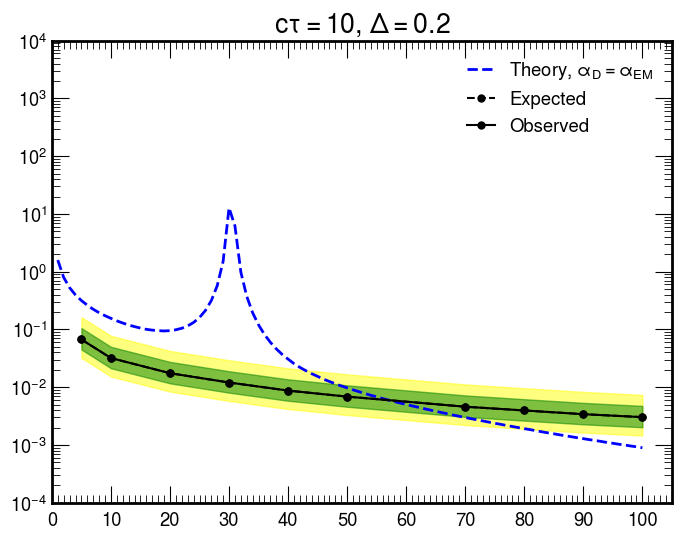

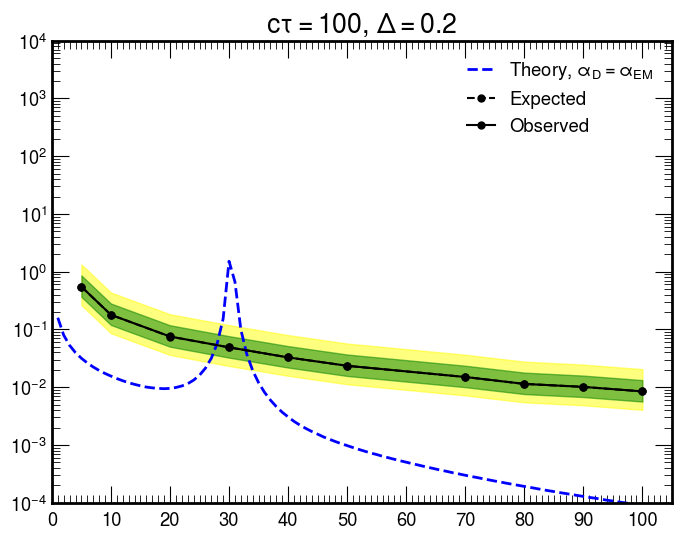

In [19]:
import os
import uproot
import pandas as pd
hcname = "skimmed_signal_2018_v11_miniAOD_aEM_rdfSkim_MET200_nJetsG0_NJetL4.coffea"
hbname = "skimmed_bkg_2018_v9_miniAOD_rdfSkim_MET200_nJetsG0_NJetL4.coffea"
base="/uscms/home/sbrightt/nobackup/iDM/iDMe_analysis/CMSSW_11_3_4/src/iDMe_limits/BDT_latest/NJetsL4/"
hcs, hcb, dfs, cfs, cfb, sig_tots, nbkg_tot = get_stuff(hcname,hbname,"cut9")

xs = pd.read_csv('/uscms_data/d3/sbrightt/iDMe/signal_xsec/condor/signal_xsec_table.csv')
xs = xs[xs.alphaD=="aEM"]
xs = xs[xs['mA/m1'] == 3]

root_files = [f for f in os.listdir(base) if '.root' in f]
m1s = []
cts = []
deltas = []
rs = []
rs_plus1 = []
rs_minus1 = []
rs_plus2 = []
rs_minus2 = []
robs = []
xsecs = []
for rf in root_files:
    point = rf.split('.')[1]
    delta,m1,ct = point.split("_")
    if delta == 0.4:
        continue
    delta = float(delta[5:])/100
    m1 = float(m1[1:])
    ct = float(ct[2:])
    with uproot.open(base+rf)['limit'] as rootf:
        lims = rootf['limit'].array().to_numpy()
    if len(lims) < 5:
        continue
    xsecs.append(xs[(xs.m1==m1)&(xs.delta==delta)&(xs.ctau==ct)]['xs'].iloc[0])
    deltas.append(delta)
    m1s.append(m1)
    cts.append(ct)
    rs_minus2.append(lims[0])
    rs_minus1.append(lims[1])
    rs.append(lims[2])
    rs_plus1.append(lims[3])
    rs_plus2.append(lims[4])
    robs.append(lims[5])
lims = pd.DataFrame({
    "m1":m1s,
    "ct":cts,
    "delta":deltas,
    "r":rs,
    "rp1":rs_plus1,
    "rm1":rs_minus1,
    "rp2":rs_plus2,
    "rm2":rs_minus2,
    "robs":robs,
    "xsec":xsecs
})

noms_NJetL4 = {}
robs_NJetL4 = {}
m1s_NJetL4 = {}

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

deltas = [0.1,0.2]
all_ctaus = [1,10,100]
for d in deltas:
    for i,ct in enumerate(all_ctaus):
        plt.figure(figsize=(8,6))
        mass1s = sorted(list(set(lims[(lims.delta==d)&(lims.ct==ct)].m1.array.to_numpy())))
        theory_xsec = xs[(xs.delta==d)&(xs.ctau==ct)]["xs"].array.to_numpy()
        theory_m1 = xs[(xs.delta==d)&(xs.ctau==ct)]["m1"].array.to_numpy()
        srt = np.argsort(theory_m1)
        theory_m1 = theory_m1[srt]
        theory_xsec = theory_xsec[srt]
        plt.title(r"$c \tau = {0}$, $\Delta = {1}$".format(ct,d))
        plt.plot(theory_m1,theory_xsec,color="blue",linestyle="--",linewidth=2,label=r"Theory, $\alpha_D = \alpha_\mathrm{EM}$")
        
        noms = []
        p1s = []
        m1s = []
        p2s = []
        m2s = []
        obs = []
        for m1 in mass1s:
            scale = 1.0
            sig_pt = dfs[(dfs.delta==d)&(dfs.ctau==ct)&(dfs.m1==m1)].name[0]
            if sig_tots[sig_pt] >= 300:
                scale = 1.0/(300*(sig_tots[sig_pt]/300))
            robs = lims[(lims.delta==d)&(lims.ct==ct)&(lims.m1==m1)].robs.iloc[0]
            r = lims[(lims.delta==d)&(lims.ct==ct)&(lims.m1==m1)].r.iloc[0]
            rm1 = lims[(lims.delta==d)&(lims.ct==ct)&(lims.m1==m1)].rm1.iloc[0]
            rp1 = lims[(lims.delta==d)&(lims.ct==ct)&(lims.m1==m1)].rp1.iloc[0]
            rm2 = lims[(lims.delta==d)&(lims.ct==ct)&(lims.m1==m1)].rm2.iloc[0]
            rp2 = lims[(lims.delta==d)&(lims.ct==ct)&(lims.m1==m1)].rp2.iloc[0]
            xsec = lims[(lims.delta==d)&(lims.ct==ct)&(lims.m1==m1)].xsec.iloc[0]
            obs.append(scale*robs*xsec)
            noms.append(scale*r*xsec)
            m1s.append(scale*rm1*xsec)
            p1s.append(scale*rp1*xsec)
            m2s.append(scale*rm2*xsec)
            p2s.append(scale*rp2*xsec)
        plt.fill_between(mass1s,m2s,p2s,color="yellow",alpha=0.5)
        plt.fill_between(mass1s,m1s,p1s,color="green",alpha=0.5)
        plt.plot(mass1s,noms,color="black",marker=".",markersize=10,label="Expected",linestyle='--')
        plt.plot(mass1s,obs,color="black",marker=".",markersize=10,label="Observed",linestyle='-')
        
        noms_NJetL4[f"delta{d}_ct{ct}"] = noms
        robs_NJetL4[f"delta{d}_ct{ct}"] = obs
        m1s_NJetL4[f"delta{d}_ct{ct}"] = mass1s
        
        plt.legend()
        plt.ylim([1e-4,1e4])
        plt.yscale('log')
        plt.xlim([0,105])
        ax = plt.gca()
        ax.xaxis.set_major_locator(MultipleLocator(10))
        ax.xaxis.set_major_formatter('{x:.0f}')
        ax.xaxis.set_minor_locator(MultipleLocator(1))
        #plt.savefig(f"plots/expected_lims/delta{d}_ct{ct}.pdf")

# With NJets < 4 & ISR Only

NBKG =  3.738359935008307


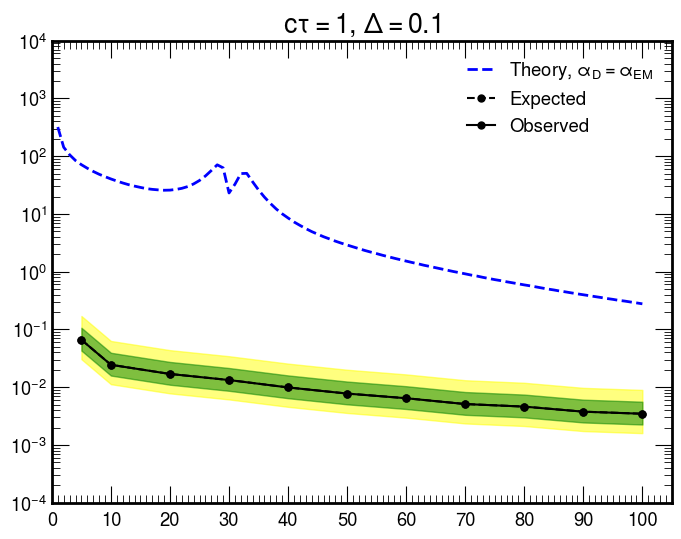

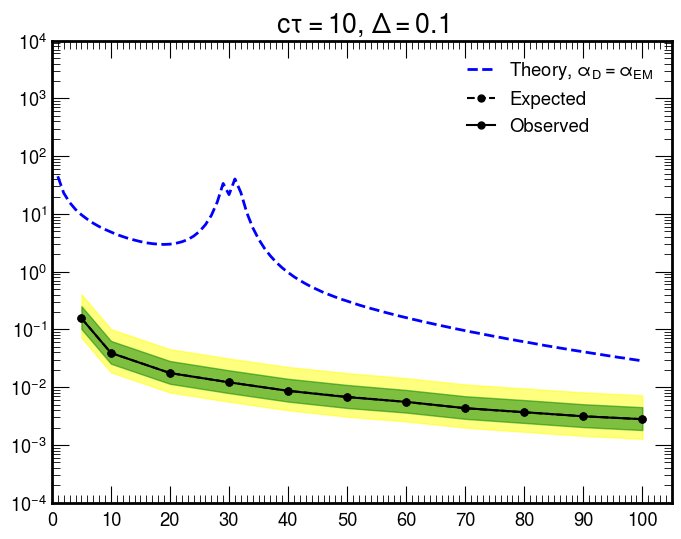

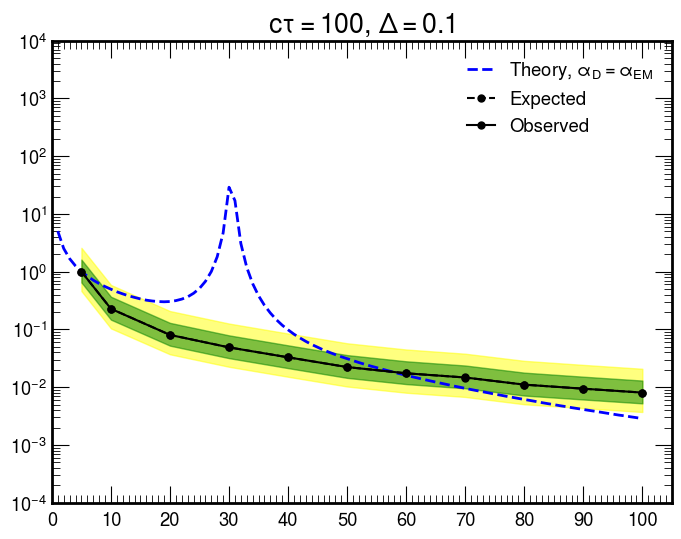

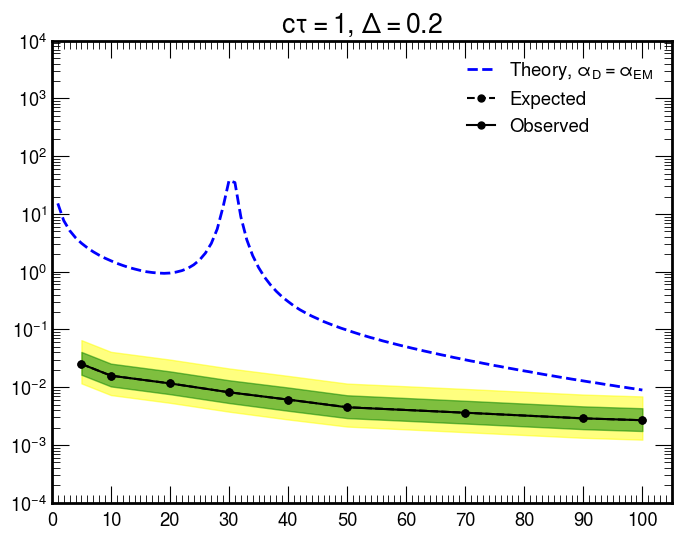

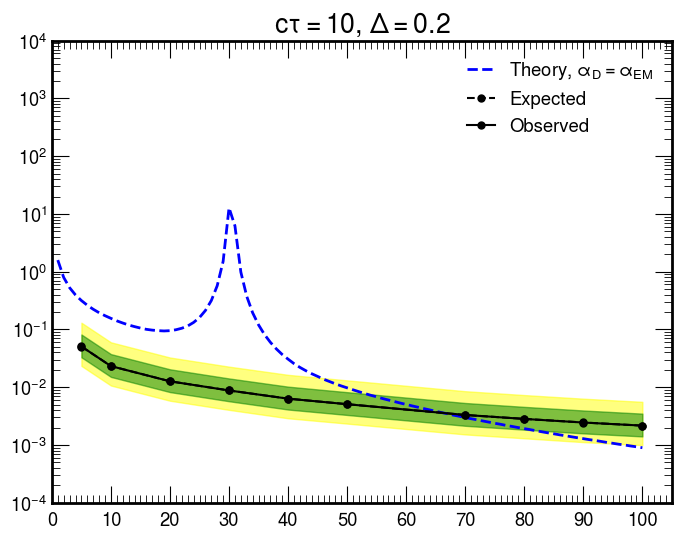

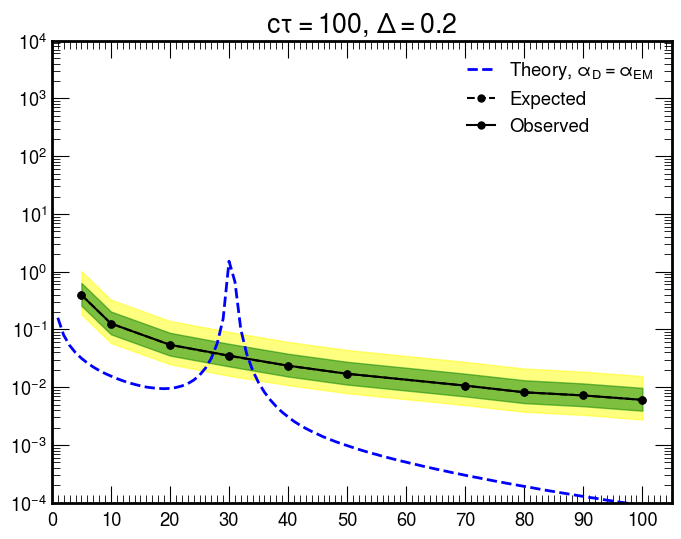

In [20]:
import os
import uproot
import pandas as pd
hcname = "skimmed_signal_2018_v11_miniAOD_aEM_rdfSkim_MET200_nJetsG0_NJetL4_ISRonly.coffea"
hbname = "skimmed_bkg_2018_v9_miniAOD_rdfSkim_MET200_nJetsG0_NJetL4_ISRonly.coffea"
base="/uscms/home/sbrightt/nobackup/iDM/iDMe_analysis/CMSSW_11_3_4/src/iDMe_limits/BDT_latest/NJetsL4_ISRonly/"
hcs, hcb, dfs, cfs, cfb, sig_tots, nbkg_tot = get_stuff(hcname,hbname,"cut6")

xs = pd.read_csv('/uscms_data/d3/sbrightt/iDMe/signal_xsec/condor/signal_xsec_table.csv')
xs = xs[xs.alphaD=="aEM"]
xs = xs[xs['mA/m1'] == 3]

root_files = [f for f in os.listdir(base) if '.root' in f]
m1s = []
cts = []
deltas = []
rs = []
rs_plus1 = []
rs_minus1 = []
rs_plus2 = []
rs_minus2 = []
robs = []
xsecs = []
for rf in root_files:
    point = rf.split('.')[1]
    delta,m1,ct = point.split("_")
    if delta == 0.4:
        continue
    delta = float(delta[5:])/100
    m1 = float(m1[1:])
    ct = float(ct[2:])
    with uproot.open(base+rf)['limit'] as rootf:
        lims = rootf['limit'].array().to_numpy()
    if len(lims) < 5:
        continueå
    xsecs.append(xs[(xs.m1==m1)&(xs.delta==delta)&(xs.ctau==ct)]['xs'].iloc[0])
    deltas.append(delta)
    m1s.append(m1)
    cts.append(ct)
    rs_minus2.append(lims[0])
    rs_minus1.append(lims[1])
    rs.append(lims[2])
    rs_plus1.append(lims[3])
    rs_plus2.append(lims[4])
    robs.append(lims[5])
lims = pd.DataFrame({
    "m1":m1s,
    "ct":cts,
    "delta":deltas,
    "r":rs,
    "rp1":rs_plus1,
    "rm1":rs_minus1,
    "rp2":rs_plus2,
    "rm2":rs_minus2,
    "robs":robs,
    "xsec":xsecs
})

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

noms_NJetL4_ISRonly = {}
robs_NJetL4_ISRonly = {}
m1s_NJetL4_ISRonly = {}

deltas = [0.1,0.2]
all_ctaus = [1,10,100]
for d in deltas:
    for i,ct in enumerate(all_ctaus):
        plt.figure(figsize=(8,6))
        mass1s = sorted(list(set(lims[(lims.delta==d)&(lims.ct==ct)].m1.array.to_numpy())))
        theory_xsec = xs[(xs.delta==d)&(xs.ctau==ct)]["xs"].array.to_numpy()
        theory_m1 = xs[(xs.delta==d)&(xs.ctau==ct)]["m1"].array.to_numpy()
        srt = np.argsort(theory_m1)
        theory_m1 = theory_m1[srt]
        theory_xsec = theory_xsec[srt]
        plt.title(r"$c \tau = {0}$, $\Delta = {1}$".format(ct,d))
        plt.plot(theory_m1,theory_xsec,color="blue",linestyle="--",linewidth=2,label=r"Theory, $\alpha_D = \alpha_\mathrm{EM}$")
        
        noms = []
        p1s = []
        m1s = []
        p2s = []
        m2s = []
        obs = []
        for m1 in mass1s:
            scale = 1.0
            sig_pt = dfs[(dfs.delta==d)&(dfs.ctau==ct)&(dfs.m1==m1)].name[0]
            if sig_tots[sig_pt] >= 300:
                scale = 1.0/(300*(sig_tots[sig_pt]/300))
            robs = lims[(lims.delta==d)&(lims.ct==ct)&(lims.m1==m1)].robs.iloc[0]
            r = lims[(lims.delta==d)&(lims.ct==ct)&(lims.m1==m1)].r.iloc[0]
            rm1 = lims[(lims.delta==d)&(lims.ct==ct)&(lims.m1==m1)].rm1.iloc[0]
            rp1 = lims[(lims.delta==d)&(lims.ct==ct)&(lims.m1==m1)].rp1.iloc[0]
            rm2 = lims[(lims.delta==d)&(lims.ct==ct)&(lims.m1==m1)].rm2.iloc[0]
            rp2 = lims[(lims.delta==d)&(lims.ct==ct)&(lims.m1==m1)].rp2.iloc[0]
            xsec = lims[(lims.delta==d)&(lims.ct==ct)&(lims.m1==m1)].xsec.iloc[0]
            obs.append(scale*robs*xsec)
            noms.append(scale*r*xsec)
            m1s.append(scale*rm1*xsec)
            p1s.append(scale*rp1*xsec)
            m2s.append(scale*rm2*xsec)
            p2s.append(scale*rp2*xsec)
        plt.fill_between(mass1s,m2s,p2s,color="yellow",alpha=0.5)
        plt.fill_between(mass1s,m1s,p1s,color="green",alpha=0.5)
        plt.plot(mass1s,noms,color="black",marker=".",markersize=10,label="Expected",linestyle='--')
        plt.plot(mass1s,obs,color="black",marker=".",markersize=10,label="Observed",linestyle='-')
        
        noms_NJetL4_ISRonly[f"delta{d}_ct{ct}"] = noms
        robs_NJetL4_ISRonly[f"delta{d}_ct{ct}"] = obs
        m1s_NJetL4_ISRonly[f"delta{d}_ct{ct}"] = mass1s
        
        plt.legend()
        plt.ylim([1e-4,1e4])
        plt.yscale('log')
        plt.xlim([0,105])
        ax = plt.gca()
        ax.xaxis.set_major_locator(MultipleLocator(10))
        ax.xaxis.set_major_formatter('{x:.0f}')
        ax.xaxis.set_minor_locator(MultipleLocator(1))
        #plt.savefig(f"plots/expected_lims/delta{d}_ct{ct}.pdf")

# with Njets < 4 and ISR+jetMETdPhi but include jetMetdPhi vars in training

In [12]:
import os
import uproot
import pandas as pd
hcname = "skimmed_signal_2018_v11_miniAOD_aEM_rdfSkim_MET200_nJetsG0_NJetL4_useJetMETdPhiVars.coffea"
hbname = "skimmed_bkg_2018_v9_miniAOD_rdfSkim_MET200_nJetsG0_NJetL4_useJetMETdPhiVars.coffea"
base="/uscms/home/sbrightt/nobackup/iDM/iDMe_analysis/CMSSW_11_3_4/src/iDMe_limits/BDT_latest/NJetsL4_useJetMETdPhiVars/"
CUT = "cut9"
evtScale = 300

hcs, hcb, dfs, cfs, cfb, sig_tots, nbkg_tot = get_stuff(hcname,hbname,CUT)

make_cards(cfs,cfb,dfs,base,CUT,evtScale=evtScale)

NBKG =  16.5995596455057


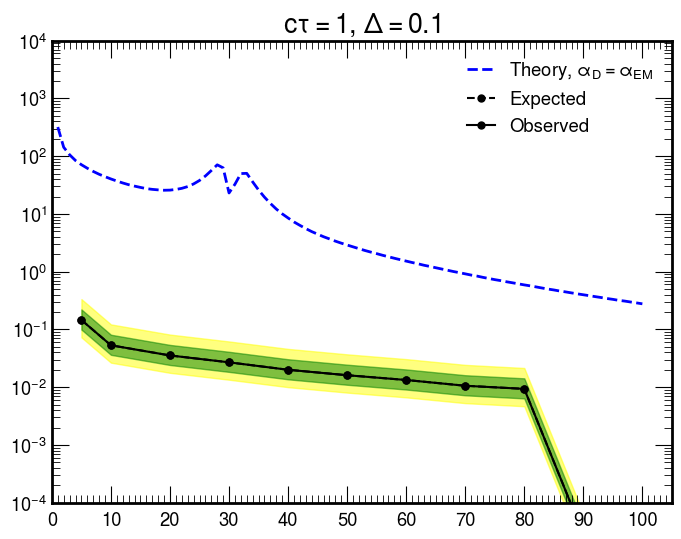

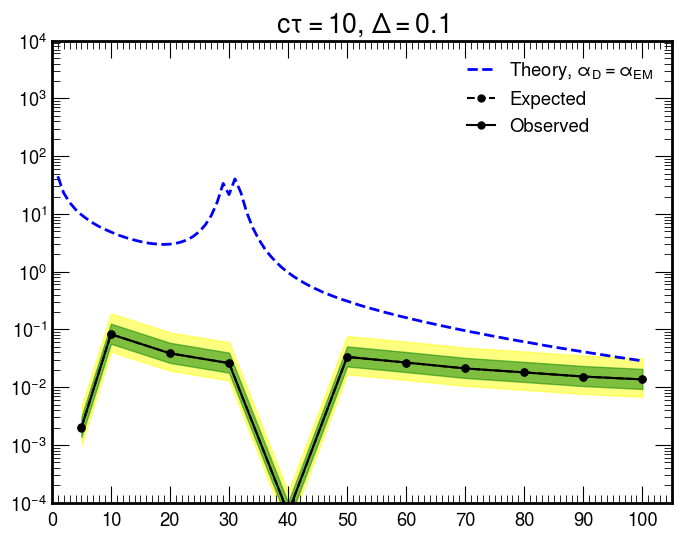

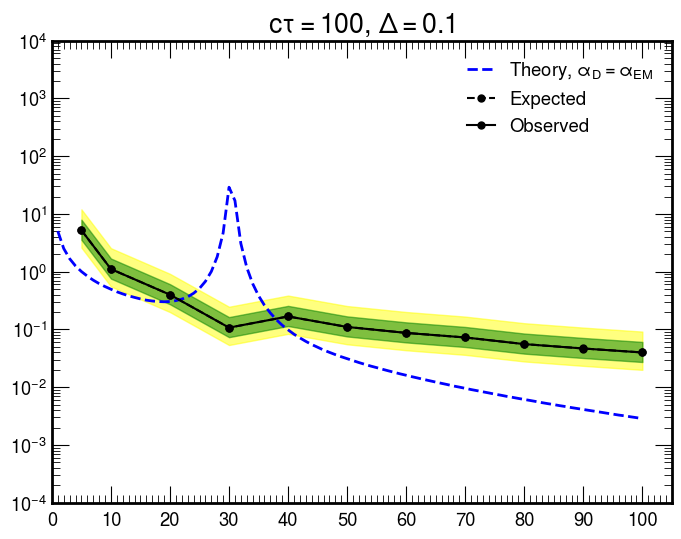

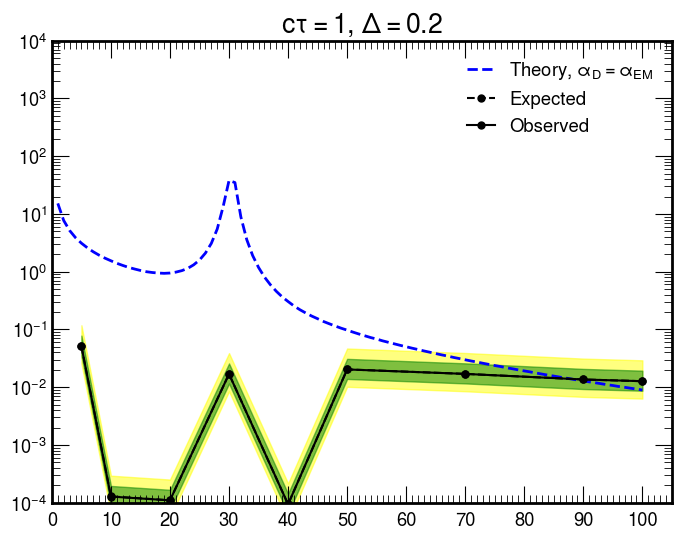

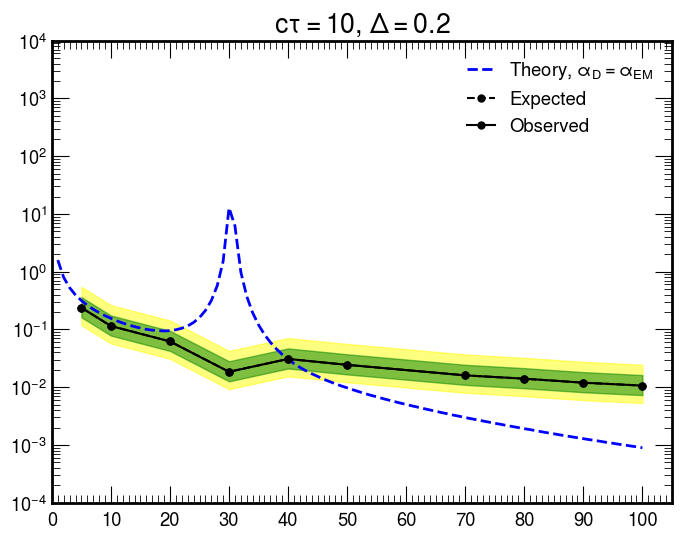

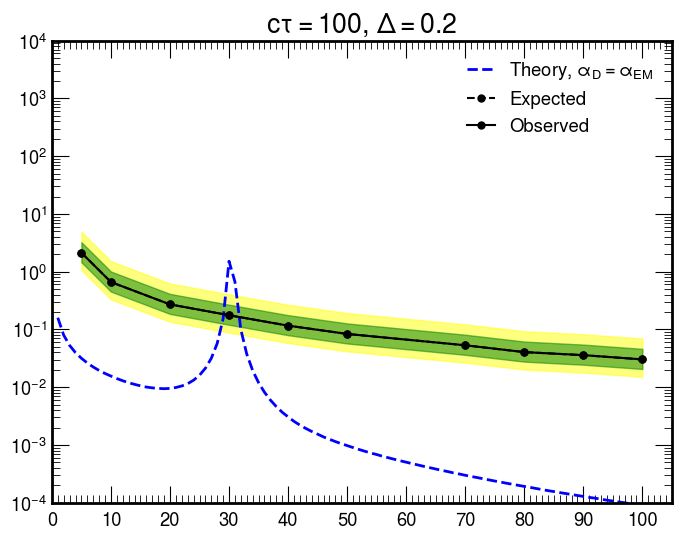

In [13]:
xs = pd.read_csv('/uscms_data/d3/sbrightt/iDMe/signal_xsec/condor/signal_xsec_table.csv')
xs = xs[xs.alphaD=="aEM"]
xs = xs[xs['mA/m1'] == 3]

root_files = [f for f in os.listdir(base) if '.root' in f]
m1s = []
cts = []
deltas = []
rs = []
rs_plus1 = []
rs_minus1 = []
rs_plus2 = []
rs_minus2 = []
robs = []
xsecs = []
for rf in root_files:
    point = rf.split('.')[1]
    delta,m1,ct = point.split("_")
    if delta == 0.4:
        continue
    delta = float(delta[5:])/100
    m1 = float(m1[1:])
    ct = float(ct[2:])
    with uproot.open(base+rf)['limit'] as rootf:
        lims = rootf['limit'].array().to_numpy()
    if len(lims) < 5:
        continueå
    xsecs.append(xs[(xs.m1==m1)&(xs.delta==delta)&(xs.ctau==ct)]['xs'].iloc[0])
    deltas.append(delta)
    m1s.append(m1)
    cts.append(ct)
    rs_minus2.append(lims[0])
    rs_minus1.append(lims[1])
    rs.append(lims[2])
    rs_plus1.append(lims[3])
    rs_plus2.append(lims[4])
    robs.append(lims[5])
lims = pd.DataFrame({
    "m1":m1s,
    "ct":cts,
    "delta":deltas,
    "r":rs,
    "rp1":rs_plus1,
    "rm1":rs_minus1,
    "rp2":rs_plus2,
    "rm2":rs_minus2,
    "robs":robs,
    "xsec":xsecs
})

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

noms_NJetL4_useJMdPhi = {}
robs_NJetL4_useJMdPhi = {}
m1s_NJetL4_useJMdPhi = {}

deltas = [0.1,0.2]
all_ctaus = [1,10,100]
for d in deltas:
    for i,ct in enumerate(all_ctaus):
        plt.figure(figsize=(8,6))
        mass1s = sorted(list(set(lims[(lims.delta==d)&(lims.ct==ct)].m1.array.to_numpy())))
        theory_xsec = xs[(xs.delta==d)&(xs.ctau==ct)]["xs"].array.to_numpy()
        theory_m1 = xs[(xs.delta==d)&(xs.ctau==ct)]["m1"].array.to_numpy()
        srt = np.argsort(theory_m1)
        theory_m1 = theory_m1[srt]
        theory_xsec = theory_xsec[srt]
        plt.title(r"$c \tau = {0}$, $\Delta = {1}$".format(ct,d))
        plt.plot(theory_m1,theory_xsec,color="blue",linestyle="--",linewidth=2,label=r"Theory, $\alpha_D = \alpha_\mathrm{EM}$")
        
        noms = []
        p1s = []
        m1s = []
        p2s = []
        m2s = []
        obs = []
        for m1 in mass1s:
            scale = 1.0
            sig_pt = dfs[(dfs.delta==d)&(dfs.ctau==ct)&(dfs.m1==m1)].name[0]
            if sig_tots[sig_pt] >= evtScale:
                scale = 1.0/(evtScale*(sig_tots[sig_pt]/evtScale))
            robs = lims[(lims.delta==d)&(lims.ct==ct)&(lims.m1==m1)].robs.iloc[0]
            r = lims[(lims.delta==d)&(lims.ct==ct)&(lims.m1==m1)].r.iloc[0]
            rm1 = lims[(lims.delta==d)&(lims.ct==ct)&(lims.m1==m1)].rm1.iloc[0]
            rp1 = lims[(lims.delta==d)&(lims.ct==ct)&(lims.m1==m1)].rp1.iloc[0]
            rm2 = lims[(lims.delta==d)&(lims.ct==ct)&(lims.m1==m1)].rm2.iloc[0]
            rp2 = lims[(lims.delta==d)&(lims.ct==ct)&(lims.m1==m1)].rp2.iloc[0]
            xsec = lims[(lims.delta==d)&(lims.ct==ct)&(lims.m1==m1)].xsec.iloc[0]
            obs.append(scale*robs*xsec)
            noms.append(scale*r*xsec)
            m1s.append(scale*rm1*xsec)
            p1s.append(scale*rp1*xsec)
            m2s.append(scale*rm2*xsec)
            p2s.append(scale*rp2*xsec)
        plt.fill_between(mass1s,m2s,p2s,color="yellow",alpha=0.5)
        plt.fill_between(mass1s,m1s,p1s,color="green",alpha=0.5)
        plt.plot(mass1s,noms,color="black",marker=".",markersize=10,label="Expected",linestyle='--')
        plt.plot(mass1s,obs,color="black",marker=".",markersize=10,label="Observed",linestyle='-')
        
        noms_NJetL4_useJMdPhi[f"delta{d}_ct{ct}"] = noms
        robs_NJetL4_useJMdPhi[f"delta{d}_ct{ct}"] = obs
        m1s_NJetL4_useJMdPhi[f"delta{d}_ct{ct}"] = mass1s
        
        plt.legend()
        plt.ylim([1e-4,1e4])
        plt.yscale('log')
        plt.xlim([0,105])
        ax = plt.gca()
        ax.xaxis.set_major_locator(MultipleLocator(10))
        ax.xaxis.set_major_formatter('{x:.0f}')
        ax.xaxis.set_minor_locator(MultipleLocator(1))
        #plt.savefig(f"plots/expected_lims/delta{d}_ct{ct}.pdf")

# With NJets < 3

In [5]:
import os
import uproot
import pandas as pd
hcname = "skimmed_signal_2018_v11_miniAOD_aEM_rdfSkim_MET200_nJetsG0_NJetL3.coffea"
hbname = "skimmed_bkg_2018_v9_miniAOD_rdfSkim_MET200_nJetsG0_NJetL3.coffea"
base="/uscms/home/sbrightt/nobackup/iDM/iDMe_analysis/CMSSW_11_3_4/src/iDMe_limits/BDT_latest/NJetsL3/"
CUT = "cut11"

hcs, hcb, dfs, cfs, cfb, sig_tots, nbkg_tot = get_stuff(hcname,hbname,CUT)
evtScale = 5*nbkg_tot

#make_cards(sig_tots,nbkg_tot,dfs,base,CUT,evtScale=evtScale)

NBKG =  14.53227752780748


In [6]:
bdt_name = "NJetsL3"

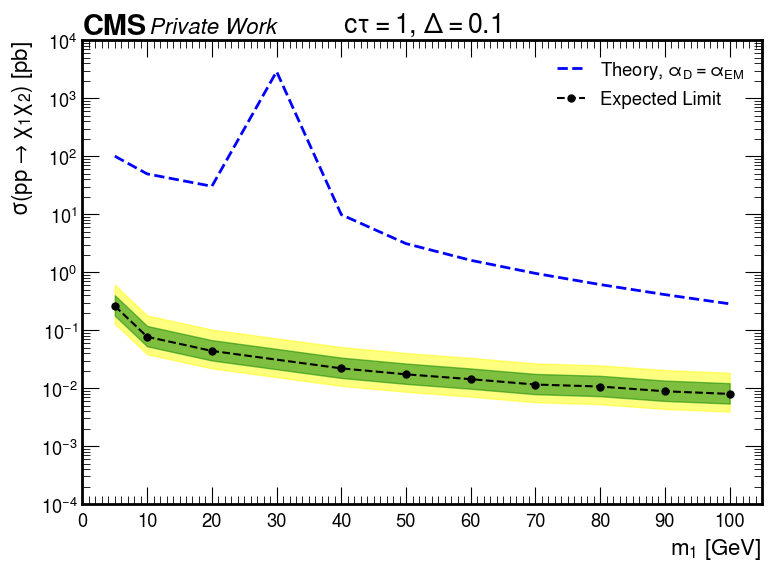

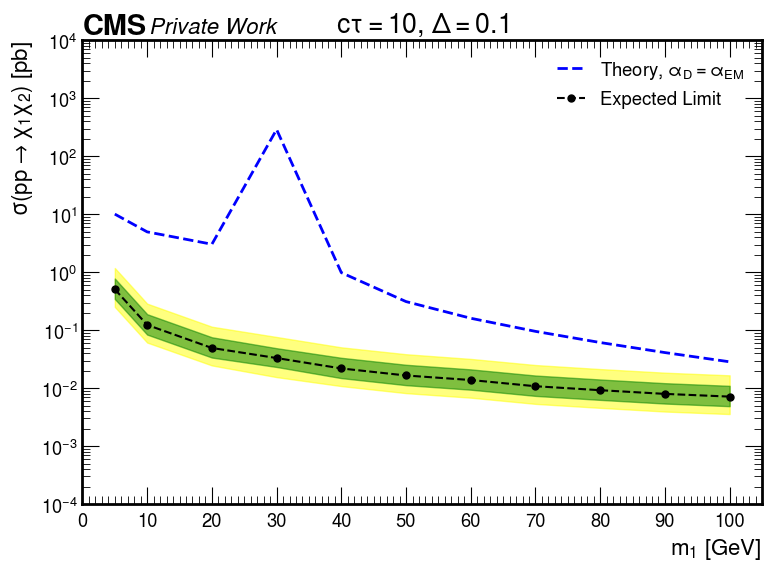

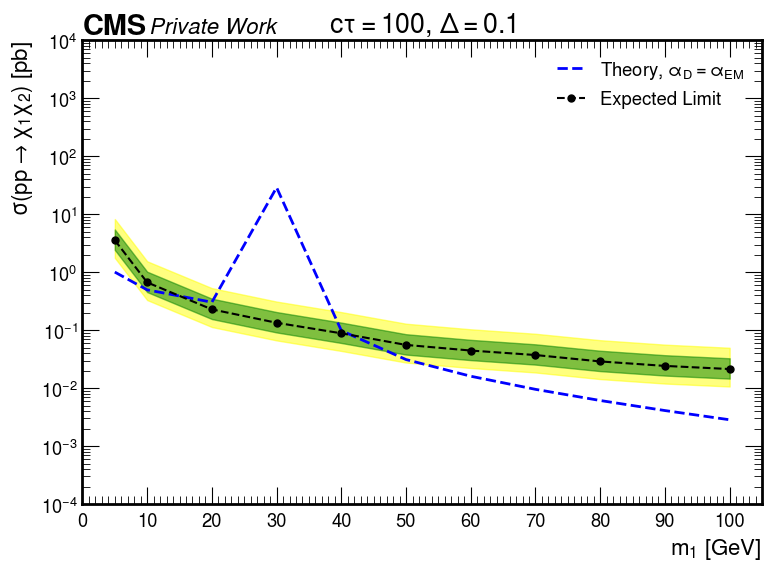

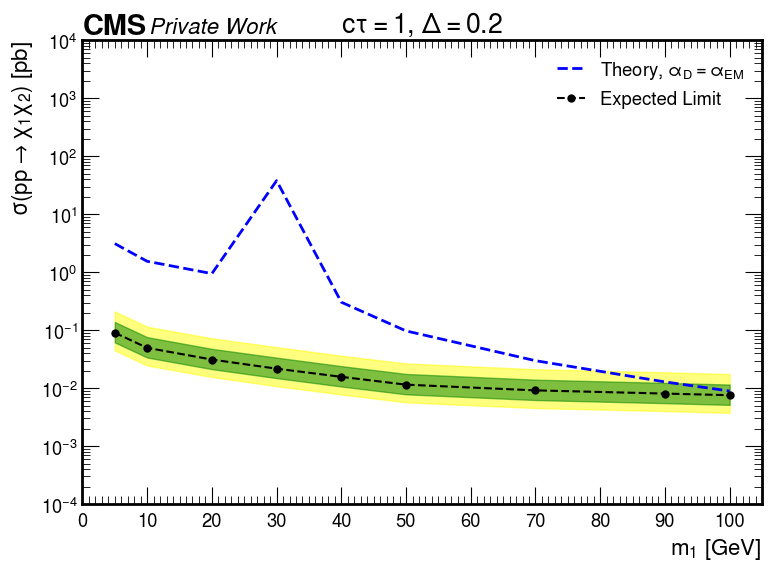

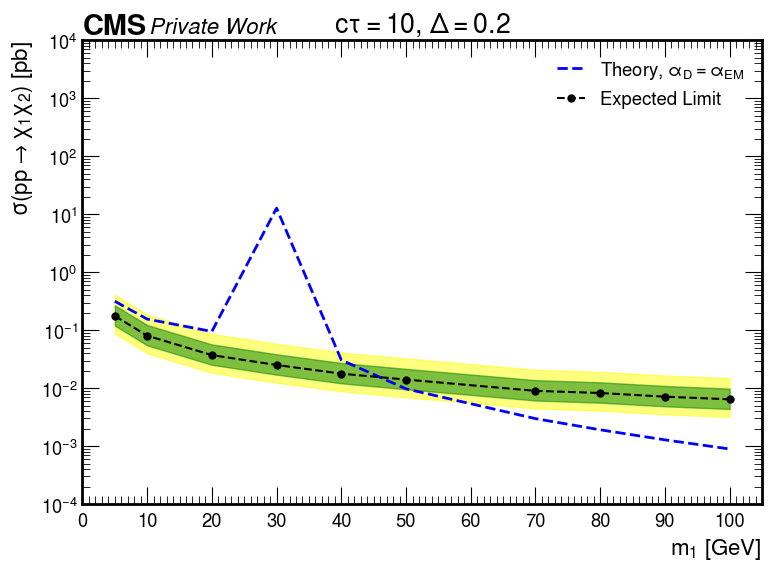

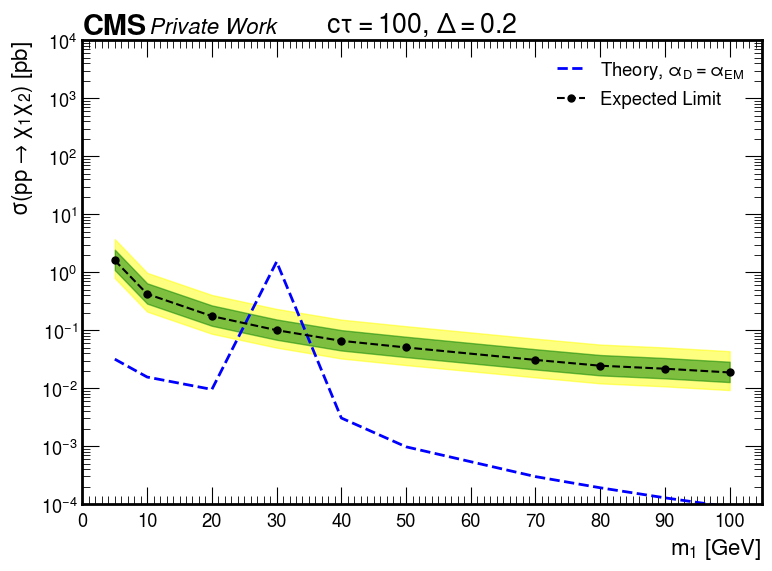

In [7]:
root_files = [f for f in os.listdir(base) if '.root' in f]
m1s = []
cts = []
deltas = []
rs = []
rs_plus1 = []
rs_minus1 = []
rs_plus2 = []
rs_minus2 = []
robs = []
xsecs = []
for rf in root_files:
    point = rf.split('.')[1]
    delta,m1,ct = point.split("_")
    if delta == 0.4:
        continue
    delta = float(delta[5:])/100
    m1 = float(m1[1:])
    ct = float(ct[2:])
    with uproot.open(base+rf)['limit'] as rootf:
        lims = rootf['limit'].array().to_numpy()
    if len(lims) < 5:
        continue
    xsecs.append(xs[(xs.m1==m1)&(xs.delta==delta)&(xs.ctau==ct)]['xs'].iloc[0])
    deltas.append(delta)
    m1s.append(m1)
    cts.append(ct)
    rs_minus2.append(lims[0])
    rs_minus1.append(lims[1])
    rs.append(lims[2])
    rs_plus1.append(lims[3])
    rs_plus2.append(lims[4])
    robs.append(lims[5])
lims = pd.DataFrame({
    "m1":m1s,
    "ct":cts,
    "delta":deltas,
    "r":rs,
    "rp1":rs_plus1,
    "rm1":rs_minus1,
    "rp2":rs_plus2,
    "rm2":rs_minus2,
    "robs":robs,
    "xsec":xsecs
})

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

noms_tmp = {}
robs_tmp = {}
m1s_tmp = {}

deltas = [0.1,0.2]
all_ctaus = [1,10,100]
for d in deltas:
    for i,ct in enumerate(all_ctaus):
        plt.figure(figsize=(8,6))
        mass1s = sorted(list(set(lims[(lims.delta==d)&(lims.ct==ct)].m1.array.to_numpy())))
        theory_xsec = xs[(xs.delta==d)&(xs.ctau==ct)]["xs"].array.to_numpy()
        theory_m1 = xs[(xs.delta==d)&(xs.ctau==ct)]["m1"].array.to_numpy()
        srt = np.argsort(theory_m1)
        theory_m1 = theory_m1[srt]
        theory_xsec = theory_xsec[srt]
        plt.title(r"$c \tau = {0}$, $\Delta = {1}$".format(ct,d))
        plt.plot(theory_m1,theory_xsec,color="blue",linestyle="--",linewidth=2,label=r"Theory, $\alpha_D = \alpha_\mathrm{EM}$")
        
        noms = []
        p1s = []
        m1s = []
        p2s = []
        m2s = []
        obs = []
        for m1 in mass1s:
            scale = 1.0
            sig_pt = dfs[(dfs.delta==d)&(dfs.ctau==ct)&(dfs.m1==m1)].name[0]
            if sig_tots[sig_pt] >= evtScale:
                scale = 1.0/evtScale
            robs = lims[(lims.delta==d)&(lims.ct==ct)&(lims.m1==m1)].robs.iloc[0]
            r = lims[(lims.delta==d)&(lims.ct==ct)&(lims.m1==m1)].r.iloc[0]
            rm1 = lims[(lims.delta==d)&(lims.ct==ct)&(lims.m1==m1)].rm1.iloc[0]
            rp1 = lims[(lims.delta==d)&(lims.ct==ct)&(lims.m1==m1)].rp1.iloc[0]
            rm2 = lims[(lims.delta==d)&(lims.ct==ct)&(lims.m1==m1)].rm2.iloc[0]
            rp2 = lims[(lims.delta==d)&(lims.ct==ct)&(lims.m1==m1)].rp2.iloc[0]
            xsec = lims[(lims.delta==d)&(lims.ct==ct)&(lims.m1==m1)].xsec.iloc[0]
            obs.append(scale*robs*xsec)
            noms.append(scale*r*xsec)
            m1s.append(scale*rm1*xsec)
            p1s.append(scale*rp1*xsec)
            m2s.append(scale*rm2*xsec)
            p2s.append(scale*rp2*xsec)
        plt.fill_between(mass1s,m2s,p2s,color="yellow",alpha=0.5)
        plt.fill_between(mass1s,m1s,p1s,color="green",alpha=0.5)
        plt.plot(mass1s,noms,color="black",marker=".",markersize=10,label="Expected Limit",linestyle='--')
        #plt.plot(mass1s,obs,color="black",marker=".",markersize=10,label="Observed",linestyle='-')
        
        noms_tmp[f"delta{d}_ct{ct}"] = noms
        robs_tmp[f"delta{d}_ct{ct}"] = obs
        m1s_tmp[f"delta{d}_ct{ct}"] = mass1s
        
        plt.legend()
        plt.ylim([1e-4,1e4])
        plt.yscale('log')
        plt.xlim([0,105])
        ax = plt.gca()
        ax.xaxis.set_major_locator(MultipleLocator(10))
        ax.xaxis.set_major_formatter('{x:.0f}')
        ax.xaxis.set_minor_locator(MultipleLocator(1))
        hep.cms.text("Private Work")
        plt.xlabel(r"$m_1$ [GeV]")
        plt.ylabel(r"$\sigma(pp \to \chi_1 \chi_2)$ [pb]")
        plt.tight_layout()
        plt.savefig(f"plots/BDT_NJetL3/expLimits_BDT_NJetL3_delta{d}_ct{ct}.pdf")
        
noms_all[bdt_name] = noms_tmp
robs_all[bdt_name] = robs_tmp
m1s_all[bdt_name] = m1s_tmp

# Njets < 3, ISR only

In [8]:
import os
import uproot
import pandas as pd
hcname = "skimmed_signal_2018_v11_miniAOD_aEM_rdfSkim_MET200_nJetsG0_NJetL3_ISRonly.coffea"
hbname = "skimmed_bkg_2018_v9_miniAOD_rdfSkim_MET200_nJetsG0_NJetL3_ISRonly.coffea"
base="/uscms/home/sbrightt/nobackup/iDM/iDMe_analysis/CMSSW_11_3_4/src/iDMe_limits/BDT_latest/NJetsL3_ISRonly/"
CUT = "cut8"

hcs, hcb, dfs, cfs, cfb, sig_tots, nbkg_tot = get_stuff(hcname,hbname,CUT)
evtScale = 5*nbkg_tot

#make_cards(sig_tots,nbkg_tot,dfs,base,CUT,evtScale=evtScale)

NBKG =  6.550397776875063


In [9]:
bdt_name = "NJetsL3_ISRonly"

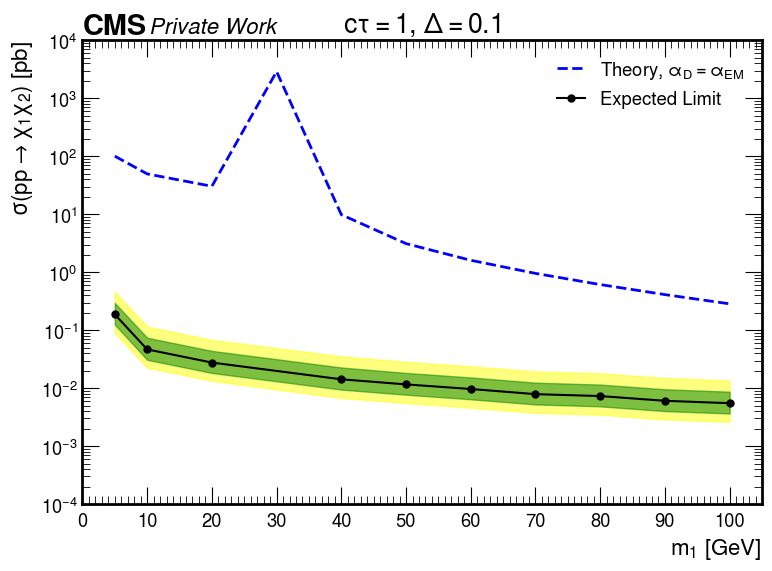

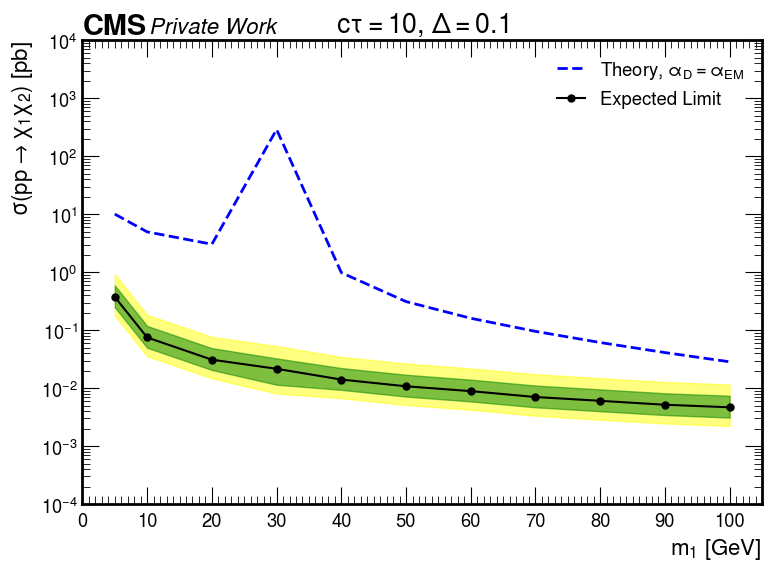

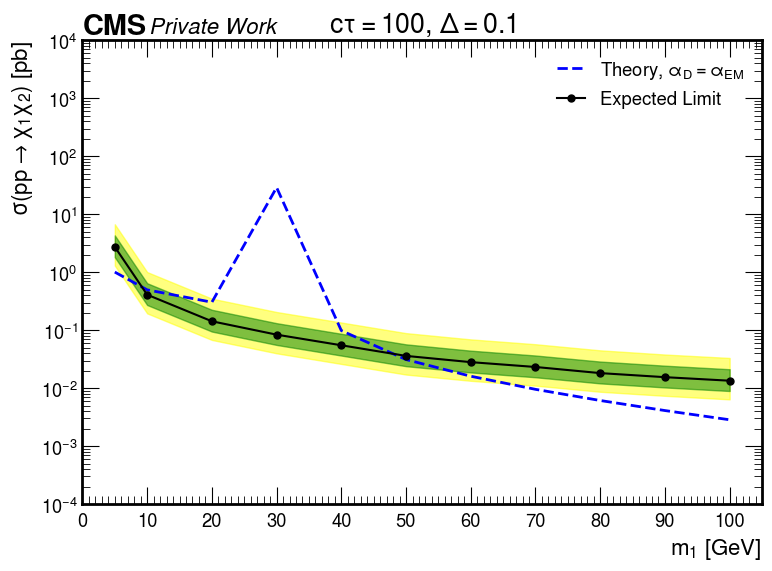

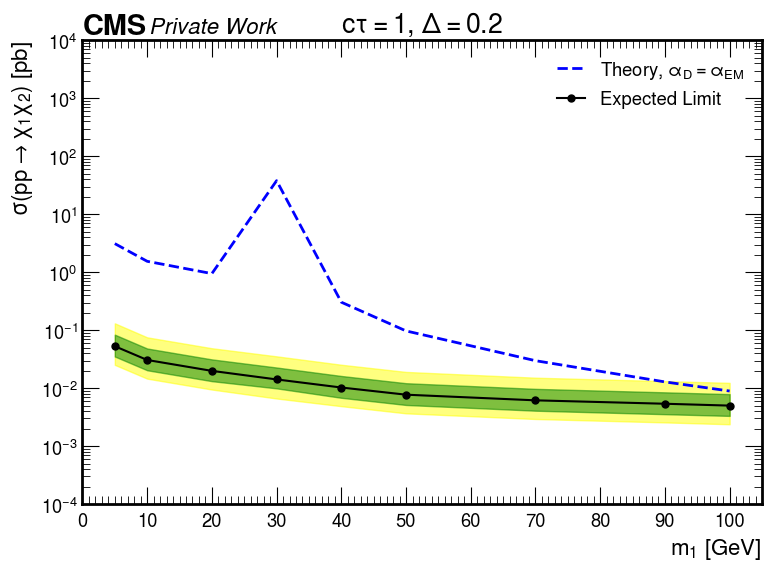

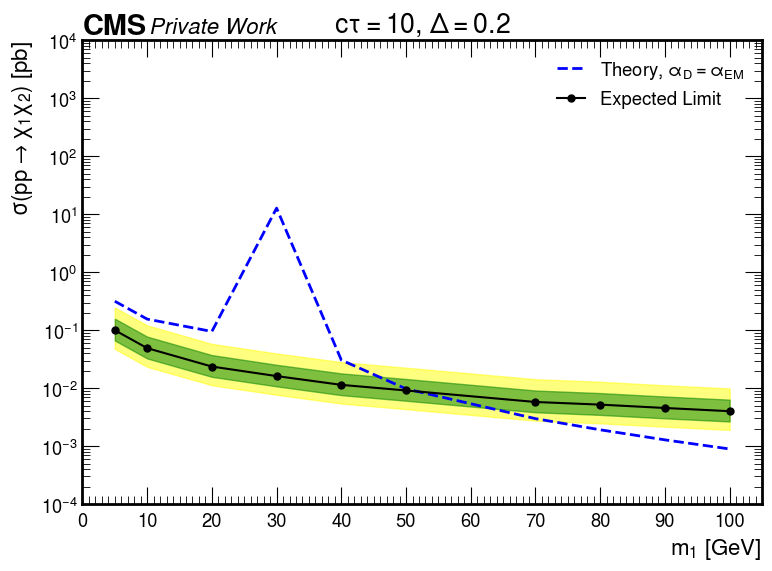

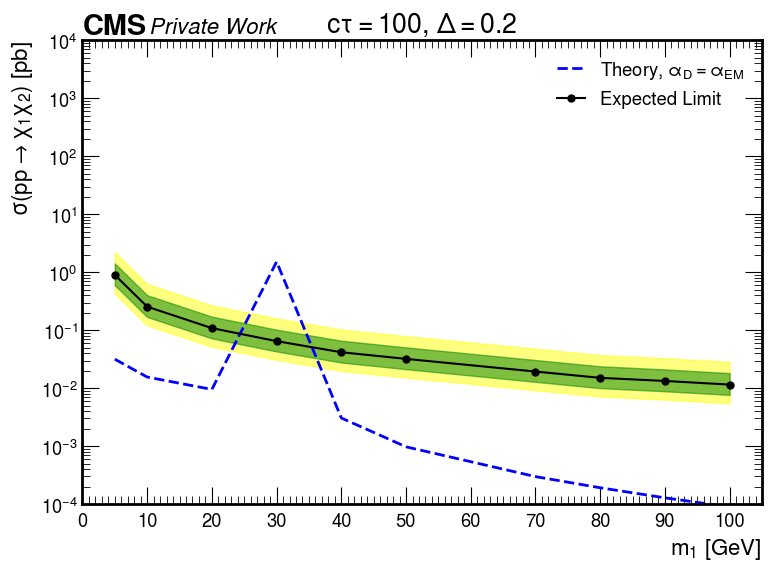

In [10]:
root_files = [f for f in os.listdir(base) if '.root' in f]
m1s = []
cts = []
deltas = []
rs = []
rs_plus1 = []
rs_minus1 = []
rs_plus2 = []
rs_minus2 = []
robs = []
xsecs = []
for rf in root_files:
    point = rf.split('.')[1]
    delta,m1,ct = point.split("_")
    if delta == 0.4:
        continue
    delta = float(delta[5:])/100
    m1 = float(m1[1:])
    ct = float(ct[2:])
    with uproot.open(base+rf)['limit'] as rootf:
        lims = rootf['limit'].array().to_numpy()
    if len(lims) < 5:
        continue
    xsecs.append(xs[(xs.m1==m1)&(xs.delta==delta)&(xs.ctau==ct)]['xs'].iloc[0])
    deltas.append(delta)
    m1s.append(m1)
    cts.append(ct)
    rs_minus2.append(lims[0])
    rs_minus1.append(lims[1])
    rs.append(lims[2])
    rs_plus1.append(lims[3])
    rs_plus2.append(lims[4])
    robs.append(lims[5])
lims = pd.DataFrame({
    "m1":m1s,
    "ct":cts,
    "delta":deltas,
    "r":rs,
    "rp1":rs_plus1,
    "rm1":rs_minus1,
    "rp2":rs_plus2,
    "rm2":rs_minus2,
    "robs":robs,
    "xsec":xsecs
})

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

noms_tmp = {}
robs_tmp = {}
m1s_tmp = {}

deltas = [0.1,0.2]
all_ctaus = [1,10,100]
for d in deltas:
    for i,ct in enumerate(all_ctaus):
        plt.figure(figsize=(8,6))
        mass1s = sorted(list(set(lims[(lims.delta==d)&(lims.ct==ct)].m1.array.to_numpy())))
        theory_xsec = xs[(xs.delta==d)&(xs.ctau==ct)]["xs"].array.to_numpy()
        theory_m1 = xs[(xs.delta==d)&(xs.ctau==ct)]["m1"].array.to_numpy()
        srt = np.argsort(theory_m1)
        theory_m1 = theory_m1[srt]
        theory_xsec = theory_xsec[srt]
        plt.title(r"$c \tau = {0}$, $\Delta = {1}$".format(ct,d))
        plt.plot(theory_m1,theory_xsec,color="blue",linestyle="--",linewidth=2,label=r"Theory, $\alpha_D = \alpha_\mathrm{EM}$")
        
        noms = []
        p1s = []
        m1s = []
        p2s = []
        m2s = []
        obs = []
        for m1 in mass1s:
            scale = 1.0
            sig_pt = dfs[(dfs.delta==d)&(dfs.ctau==ct)&(dfs.m1==m1)].name[0]
            if sig_tots[sig_pt] >= evtScale:
                scale = 1.0/evtScale
            robs = lims[(lims.delta==d)&(lims.ct==ct)&(lims.m1==m1)].robs.iloc[0]
            r = lims[(lims.delta==d)&(lims.ct==ct)&(lims.m1==m1)].r.iloc[0]
            rm1 = lims[(lims.delta==d)&(lims.ct==ct)&(lims.m1==m1)].rm1.iloc[0]
            rp1 = lims[(lims.delta==d)&(lims.ct==ct)&(lims.m1==m1)].rp1.iloc[0]
            rm2 = lims[(lims.delta==d)&(lims.ct==ct)&(lims.m1==m1)].rm2.iloc[0]
            rp2 = lims[(lims.delta==d)&(lims.ct==ct)&(lims.m1==m1)].rp2.iloc[0]
            xsec = lims[(lims.delta==d)&(lims.ct==ct)&(lims.m1==m1)].xsec.iloc[0]
            obs.append(scale*robs*xsec)
            noms.append(scale*r*xsec)
            m1s.append(scale*rm1*xsec)
            p1s.append(scale*rp1*xsec)
            m2s.append(scale*rm2*xsec)
            p2s.append(scale*rp2*xsec)
        plt.fill_between(mass1s,m2s,p2s,color="yellow",alpha=0.5)
        plt.fill_between(mass1s,m1s,p1s,color="green",alpha=0.5)
        plt.plot(mass1s,noms,color="black",marker=".",markersize=10,label="Expected Limit",linestyle='-')
        #plt.plot(mass1s,obs,color="black",marker=".",markersize=10,label="Observed",linestyle='-')
        
        noms_tmp[f"delta{d}_ct{ct}"] = noms
        robs_tmp[f"delta{d}_ct{ct}"] = obs
        m1s_tmp[f"delta{d}_ct{ct}"] = mass1s
        
        plt.legend()
        plt.ylim([1e-4,1e4])
        plt.yscale('log')
        plt.xlim([0,105])
        ax = plt.gca()
        ax.xaxis.set_major_locator(MultipleLocator(10))
        ax.xaxis.set_major_formatter('{x:.0f}')
        ax.xaxis.set_minor_locator(MultipleLocator(1))
        hep.cms.text("Private Work")
        plt.xlabel(r"$m_1$ [GeV]")
        plt.ylabel(r"$\sigma(pp \to \chi_1 \chi_2)$ [pb]")
        plt.tight_layout()
        plt.savefig(f"plots/BDT_NJetL3_ISRonly/expLimits_BDT_NJetL3_ISRonly_delta{d}_ct{ct}.pdf")
        
noms_all[bdt_name] = noms_tmp
robs_all[bdt_name] = robs_tmp
m1s_all[bdt_name] = m1s_tmp

# Comparison

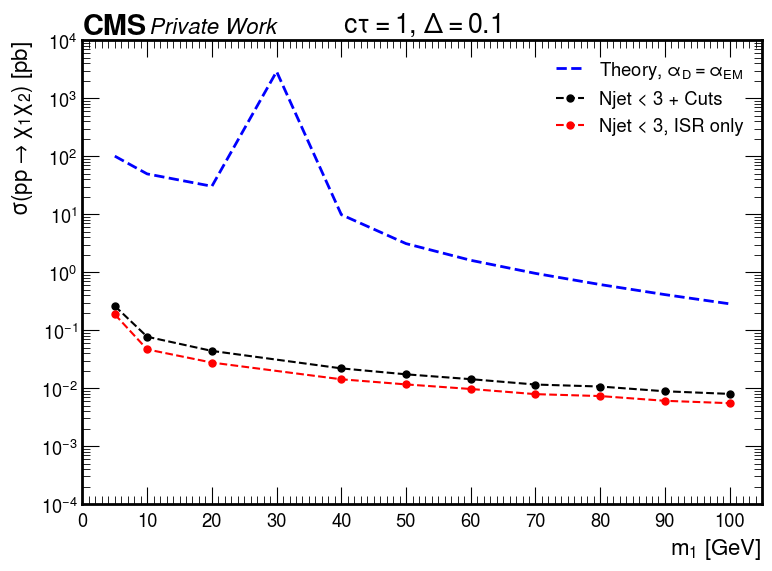

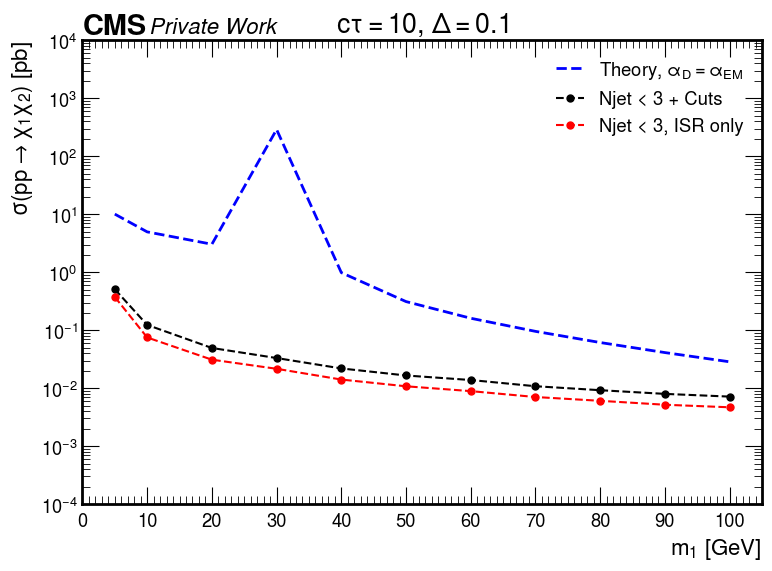

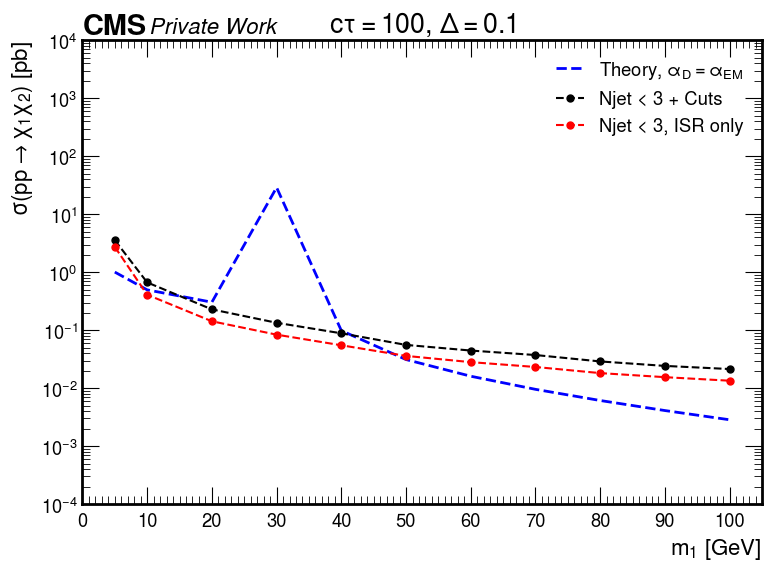

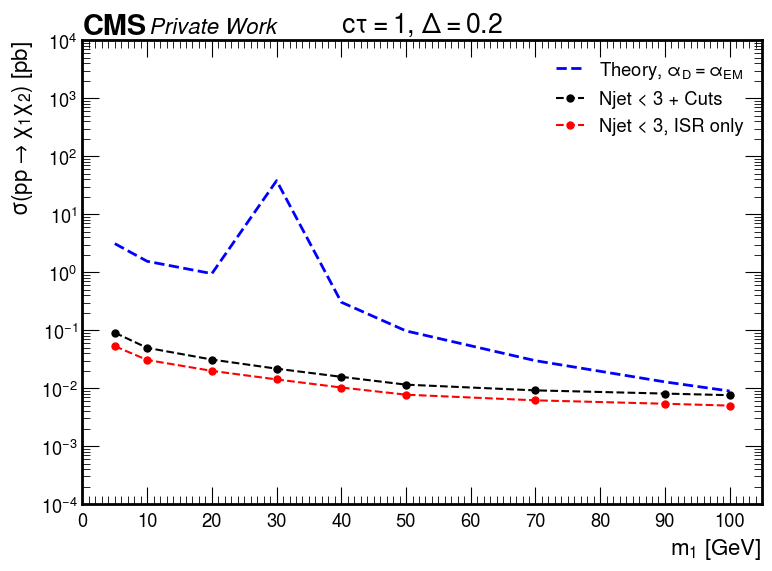

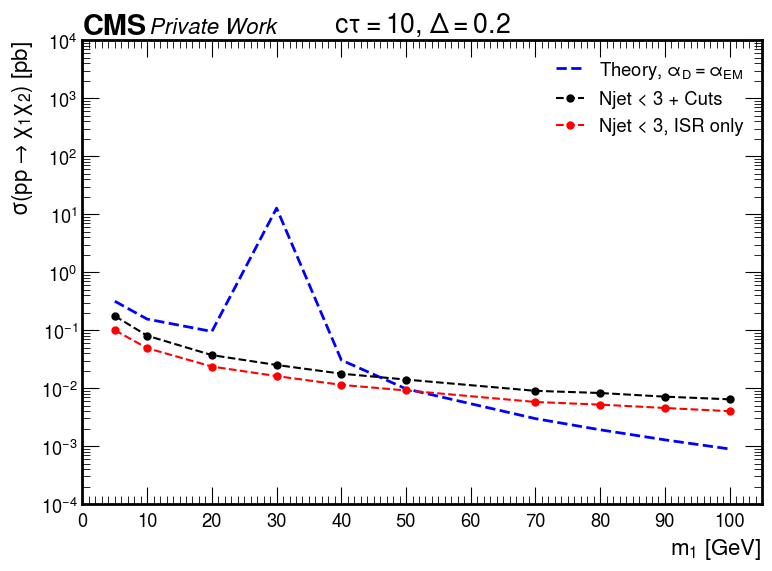

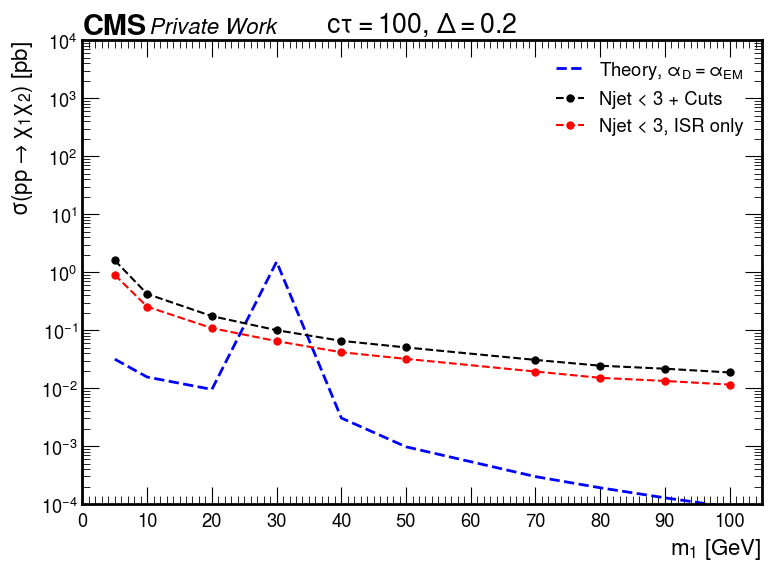

In [52]:
deltas = [0.1,0.2]
all_ctaus = [1,10,100]
for d in deltas:
    for i,ct in enumerate(all_ctaus):
        plt.figure(figsize=(8,6))
        theory_xsec = xs[(xs.delta==d)&(xs.ctau==ct)]["xs"].array.to_numpy()
        theory_m1 = xs[(xs.delta==d)&(xs.ctau==ct)]["m1"].array.to_numpy()
        srt = np.argsort(theory_m1)
        theory_m1 = theory_m1[srt]
        theory_xsec = theory_xsec[srt]
        plt.title(r"$c \tau = {0}$, $\Delta = {1}$".format(ct,d))
        plt.plot(theory_m1,theory_xsec,color="blue",linestyle="--",linewidth=2,label=r"Theory, $\alpha_D = \alpha_\mathrm{EM}$")
        
        k = f"delta{d}_ct{ct}"
        plt.plot(m1s_all["NJetsL3"][k],noms_all["NJetsL3"][k],color="black",marker=".",markersize=10,label="Njet < 3 + Cuts",linestyle='--')
        plt.plot(m1s_all["NJetsL3_ISRonly"][k],noms_all["NJetsL3_ISRonly"][k],color="red",marker=".",markersize=10,label="Njet < 3, ISR only",linestyle='--')
        #plt.plot(m1s_NJetL4_ISRonly[k],noms_NJetL4_ISRonly[k],color="green",marker=".",markersize=10,label="0 < Njet < 4, ISR only",linestyle='--')
        
        plt.legend()
        plt.ylim([1e-4,1e4])
        plt.yscale('log')
        plt.xlim([0,105])
        ax = plt.gca()
        ax.xaxis.set_major_locator(MultipleLocator(10))
        ax.xaxis.set_major_formatter('{x:.0f}')
        ax.xaxis.set_minor_locator(MultipleLocator(1))
        hep.cms.text("Private Work")
        plt.xlabel(r"$m_1$ [GeV]")
        plt.ylabel(r"$\sigma(pp \to \chi_1 \chi_2)$ [pb]")
        plt.tight_layout()
        plt.savefig(f"plots/comparison/expLimits_NJet3_withWithoutISRonly_delta{d}_ct{ct}.pdf")

# 2D $(m_1,y)$ plane

In [11]:
from scipy.constants import physical_constants as pc
hbar_c = 0.1973269804e-12 # in GeV mm
aEM = pc['fine-structure constant'][0]

def get_eps(m1,x,R,ctau,alphaD):
    mA = R*m1
    delta = x*m1
    eps = np.sqrt((hbar_c/ctau)*(15*np.pi*mA**4)/(4*aEM*alphaD*delta**5))
    return eps


In [18]:
sorted(list(set(dfs[dfs.delta==0.1].m1)))

[5.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]

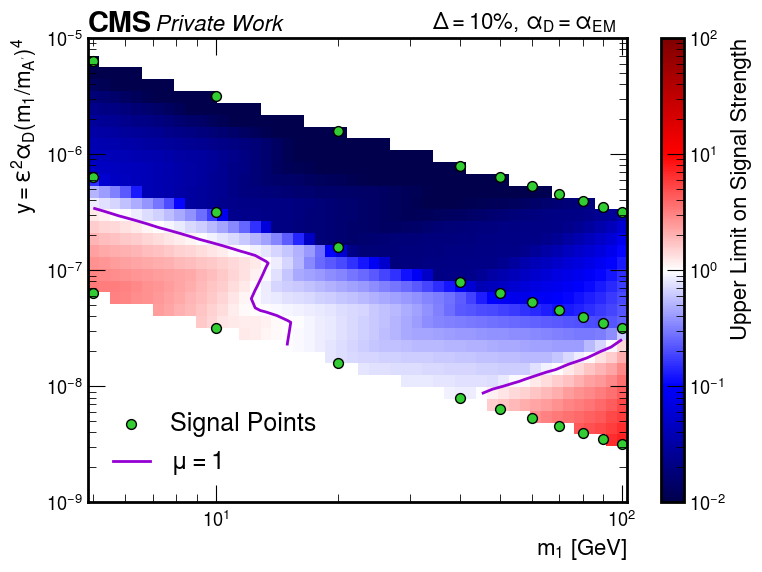

In [217]:
# 10% splitting
from scipy.interpolate import LinearNDInterpolator, CloughTocher2DInterpolator
from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D
DELTA = 0.1

cts = [1,10,100]
output_m1 = {ct:[] for ct in cts}
output_robs = {ct:[] for ct in cts}
m1s = m1s_all['NJetsL3']
robs = noms_all['NJetsL3']
for k in m1s.keys():
    if f'delta{DELTA}' not in k:
        continue
    ct = int(k.split("_")[1][2:])
    output_m1[ct] = m1s[k]
    output_robs[ct] = robs[k]

output_grid = {}
for ct in cts:
    masses = output_m1[ct]
    for i,m in enumerate(masses):
        if m == 30:
            continue
        eps = get_eps(m,DELTA,3,ct,aEM)
        y = (eps**2)*aEM/(3**4)
        cross_sec = list(xs[(xs.m1==m)&(xs.ctau==ct)&(xs.delta==DELTA)]['xs'])[0]
        output_grid[(m,y)] = output_robs[ct][i]/cross_sec

xyvals = list(output_grid.keys())
xyvals_log = [(np.log10(p[0]),np.log10(p[1])) for p in xyvals]
zvals = [output_grid[xy] for xy in xyvals]
interp = LinearNDInterpolator(xyvals_log, zvals)

#xrange = np.logspace(np.log10(5),2,50)
#yrange = np.logspace(-10,-5,50)
xrange = np.linspace(np.log10(5),2,50)
yrange = np.linspace(-10,-5,50)
X,Y = np.meshgrid(xrange,yrange)
Z = interp(X, Y)

plt.figure(figsize=(8,6))
plt.pcolormesh(10**X, 10**Y, Z, shading='auto',norm=LogNorm(vmin=1e-2,vmax=1e2),cmap='seismic')
plt.colorbar(label='Upper Limit on Signal Strength')
plt.yscale('log')
plt.xscale('log')
plt.ylim([1e-9,1e-5])
#plt.xlim([4.6,110])
a=plt.scatter([p[0] for p in xyvals],[p[1] for p in xyvals],marker='o',color='limegreen',edgecolor='k',s=50,label="Signal Points")
cs = plt.contour(10**X, 10**Y, Z, [1],colors='darkviolet',linewidths=2)
plt.xlabel(r"$m_1$ [GeV]")
handles = [a,Line2D([],[],color='darkviolet',lw=2,label=r"$\mu = 1$")]
plt.legend(handles=handles,loc='lower left',fontsize=18)
hep.cms.text("Private Work")
plt.text(34,1.2e-5,rf"$\Delta = {int(100*DELTA)}\%$, $\alpha_D = \alpha_\mathrm{{EM}}$")
plt.ylabel(r"$y = \epsilon^2\alpha_D(m_1/m_{A^\prime})^4$")
plt.tight_layout()
plt.savefig("plots/BDT_NJetL3/2Dexclusion_delta10.pdf")

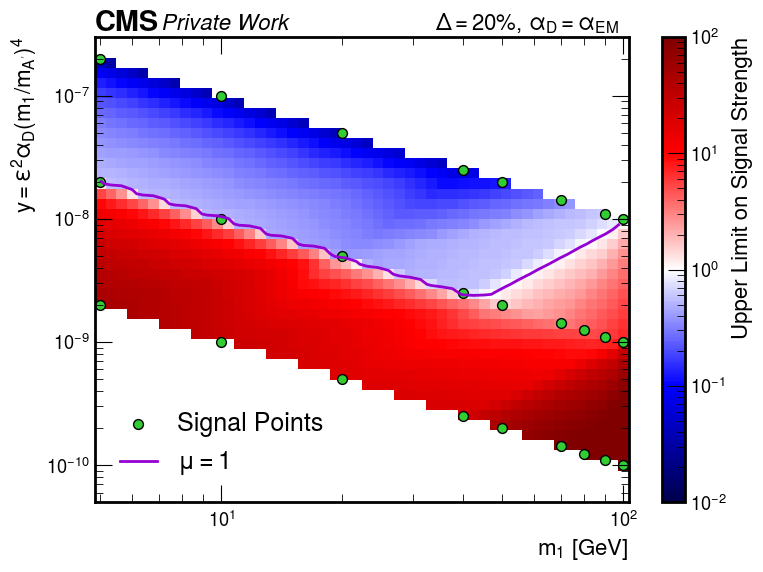

In [218]:
# 20% splitting
from scipy.interpolate import LinearNDInterpolator, CloughTocher2DInterpolator
from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D
DELTA = 0.2

cts = [1,10,100]
output_m1 = {ct:[] for ct in cts}
output_robs = {ct:[] for ct in cts}
m1s = m1s_all['NJetsL3']
robs = noms_all['NJetsL3']
for k in m1s.keys():
    if f'delta{DELTA}' not in k:
        continue
    ct = int(k.split("_")[1][2:])
    output_m1[ct] = m1s[k]
    output_robs[ct] = robs[k]

output_grid = {}
for ct in cts:
    masses = output_m1[ct]
    for i,m in enumerate(masses):
        if m == 30:
            continue
        eps = get_eps(m,DELTA,3,ct,aEM)
        y = (eps**2)*aEM/(3**4)
        cross_sec = list(xs[(xs.m1==m)&(xs.ctau==ct)&(xs.delta==DELTA)]['xs'])[0]
        output_grid[(m,y)] = output_robs[ct][i]/cross_sec

xyvals = list(output_grid.keys())
xyvals_log = [(np.log10(p[0]),np.log10(p[1])) for p in xyvals]
zvals = [output_grid[xy] for xy in xyvals]
interp = LinearNDInterpolator(xyvals_log, zvals)

#xrange = np.logspace(np.log10(5),2,50)
#yrange = np.logspace(-10,-6,50)
xrange = np.linspace(np.log10(5),2,50)
yrange = np.linspace(-10,-6,50)
#yrange_lo = (get_eps(xrange,DELTA,3,1,aEM)**2)*aEM/(3**4)
#yrange_hi = (get_eps(xrange,DELTA,3,1,aEM)**2)*aEM/(3**4)
X,Y = np.meshgrid(xrange,yrange)
#for i in range(Y.shape[1]):
#    xi = X[0,i]
#    ylo = (get_eps(xi,DELTA,3,100,aEM)**2)*aEM/(3**4)
#    yhi = 10*(get_eps(xi,DELTA,3,1,aEM)**2)*aEM/(3**4)
#    Y[:,i] = np.logspace(np.log10(ylo),np.log10(yhi),50)
Z = interp(X, Y)
#for i in range(Y.shape[0]):
#    xi = X[0,i]
#    ylo = (get_eps(xi,DELTA,3,100,aEM)**2)*aEM/(3**4)
#    yhi = (get_eps(xi,DELTA,3,1,aEM)**2)*aEM/(3**4)
#    zvals = Z[:,i]
#    yvals = Y[:,i]
#    zvals[yvals>yhi] = np.nan
#    Z[:,i] = zvals

plt.figure(figsize=(8,6))
plt.pcolormesh(10**X, 10**Y, Z, shading='auto',norm=LogNorm(vmin=1e-2,vmax=1e2),cmap='seismic')
plt.colorbar(label='Upper Limit on Signal Strength')
plt.yscale('log')
plt.xscale('log')
plt.ylim([0.5e-10,3e-7])
a=plt.scatter([p[0] for p in xyvals],[p[1] for p in xyvals],marker='o',color='limegreen',edgecolor='k',s=50,label="Signal Points")
cs = plt.contour(10**X, 10**Y, Z, [1],colors='darkviolet',linewidths=2)
plt.xlabel(r"$m_1$ [GeV]")
handles = [a,Line2D([],[],color='darkviolet',lw=2,label=r"$\mu = 1$")]
plt.legend(handles=handles,loc='lower left',fontsize=18)
hep.cms.text("Private Work")
plt.text(34,3.4e-7,rf"$\Delta = {int(100*DELTA)}\%$, $\alpha_D = \alpha_\mathrm{{EM}}$")
plt.ylabel(r"$y = \epsilon^2\alpha_D(m_1/m_{A^\prime})^4$")
plt.tight_layout()
plt.savefig("plots/BDT_NJetL3/2Dexclusion_delta20.pdf")

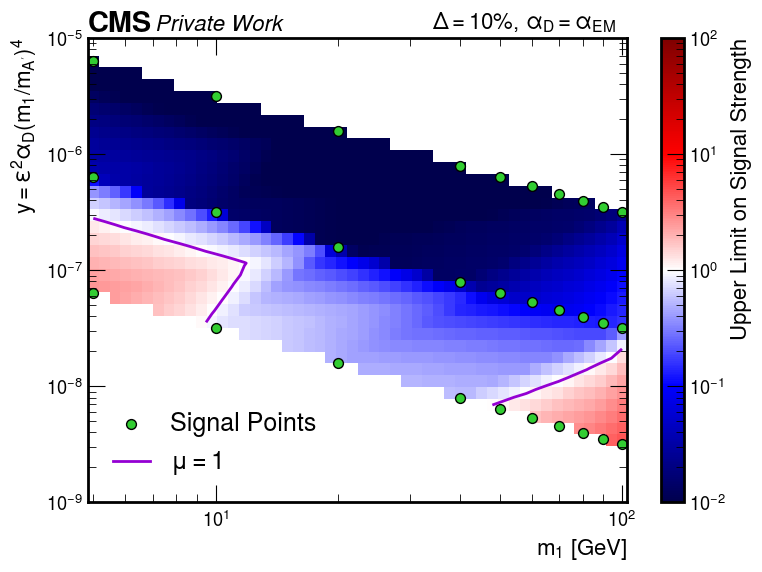

In [219]:
# 10% splitting
from scipy.interpolate import LinearNDInterpolator, CloughTocher2DInterpolator
from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D
DELTA = 0.1

cts = [1,10,100]
output_m1 = {ct:[] for ct in cts}
output_robs = {ct:[] for ct in cts}
m1s = m1s_all['NJetsL3_ISRonly']
robs = noms_all['NJetsL3_ISRonly']
for k in m1s.keys():
    if f'delta{DELTA}' not in k:
        continue
    ct = int(k.split("_")[1][2:])
    output_m1[ct] = m1s[k]
    output_robs[ct] = robs[k]

output_grid = {}
for ct in cts:
    masses = output_m1[ct]
    for i,m in enumerate(masses):
        if m == 30:
            continue
        eps = get_eps(m,DELTA,3,ct,aEM)
        y = (eps**2)*aEM/(3**4)
        cross_sec = list(xs[(xs.m1==m)&(xs.ctau==ct)&(xs.delta==DELTA)]['xs'])[0]
        output_grid[(m,y)] = output_robs[ct][i]/cross_sec

xyvals = list(output_grid.keys())
xyvals_log = [(np.log10(p[0]),np.log10(p[1])) for p in xyvals]
zvals = [output_grid[xy] for xy in xyvals]
interp = LinearNDInterpolator(xyvals_log, zvals)

#xrange = np.logspace(np.log10(5),2,50)
#yrange = np.logspace(-10,-5,50)
xrange = np.linspace(np.log10(5),2,50)
yrange = np.linspace(-10,-5,50)
X,Y = np.meshgrid(xrange,yrange)
Z = interp(X, Y)

plt.figure(figsize=(8,6))
plt.pcolormesh(10**X, 10**Y, Z, shading='auto',norm=LogNorm(vmin=1e-2,vmax=1e2),cmap='seismic')
plt.colorbar(label='Upper Limit on Signal Strength')
plt.yscale('log')
plt.xscale('log')
plt.ylim([1e-9,1e-5])
#plt.xlim([4.6,110])
a=plt.scatter([p[0] for p in xyvals],[p[1] for p in xyvals],marker='o',color='limegreen',edgecolor='k',s=50,label="Signal Points")
cs = plt.contour(10**X, 10**Y, Z, [1],colors='darkviolet',linewidths=2)
plt.xlabel(r"$m_1$ [GeV]")
handles = [a,Line2D([],[],color='darkviolet',lw=2,label=r"$\mu = 1$")]
plt.legend(handles=handles,loc='lower left',fontsize=18)
hep.cms.text("Private Work")
plt.text(34,1.2e-5,rf"$\Delta = {int(100*DELTA)}\%$, $\alpha_D = \alpha_\mathrm{{EM}}$")
plt.ylabel(r"$y = \epsilon^2\alpha_D(m_1/m_{A^\prime})^4$")
plt.tight_layout()
plt.savefig("plots/BDT_NJetL3_ISRonly/2Dexclusion_delta10.pdf")

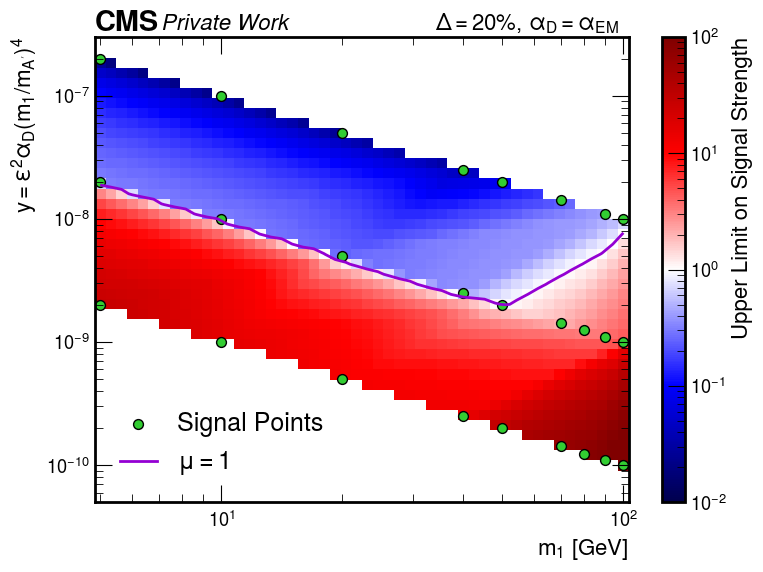

In [220]:
# 20% splitting
from scipy.interpolate import LinearNDInterpolator, CloughTocher2DInterpolator
from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D
DELTA = 0.2

cts = [1,10,100]
output_m1 = {ct:[] for ct in cts}
output_robs = {ct:[] for ct in cts}
m1s = m1s_all['NJetsL3_ISRonly']
robs = noms_all['NJetsL3_ISRonly']
for k in m1s.keys():
    if f'delta{DELTA}' not in k:
        continue
    ct = int(k.split("_")[1][2:])
    output_m1[ct] = m1s[k]
    output_robs[ct] = robs[k]

output_grid = {}
for ct in cts:
    masses = output_m1[ct]
    for i,m in enumerate(masses):
        if m == 30:
            continue
        eps = get_eps(m,DELTA,3,ct,aEM)
        y = (eps**2)*aEM/(3**4)
        cross_sec = list(xs[(xs.m1==m)&(xs.ctau==ct)&(xs.delta==DELTA)]['xs'])[0]
        output_grid[(m,y)] = output_robs[ct][i]/cross_sec

xyvals = list(output_grid.keys())
xyvals_log = [(np.log10(p[0]),np.log10(p[1])) for p in xyvals]
zvals = [output_grid[xy] for xy in xyvals]
interp = LinearNDInterpolator(xyvals_log, zvals)

#xrange = np.logspace(np.log10(5),2,50)
#yrange = np.logspace(-10,-6,50)
xrange = np.linspace(np.log10(5),2,50)
yrange = np.linspace(-10,-6,50)
#yrange_lo = (get_eps(xrange,DELTA,3,1,aEM)**2)*aEM/(3**4)
#yrange_hi = (get_eps(xrange,DELTA,3,1,aEM)**2)*aEM/(3**4)
X,Y = np.meshgrid(xrange,yrange)
#for i in range(Y.shape[1]):
#    xi = X[0,i]
#    ylo = (get_eps(xi,DELTA,3,100,aEM)**2)*aEM/(3**4)
#    yhi = 10*(get_eps(xi,DELTA,3,1,aEM)**2)*aEM/(3**4)
#    Y[:,i] = np.logspace(np.log10(ylo),np.log10(yhi),50)
Z = interp(X, Y)
#for i in range(Y.shape[0]):
#    xi = X[0,i]
#    ylo = (get_eps(xi,DELTA,3,100,aEM)**2)*aEM/(3**4)
#    yhi = (get_eps(xi,DELTA,3,1,aEM)**2)*aEM/(3**4)
#    zvals = Z[:,i]
#    yvals = Y[:,i]
#    zvals[yvals>yhi] = np.nan
#    Z[:,i] = zvals

plt.figure(figsize=(8,6))
plt.pcolormesh(10**X, 10**Y, Z, shading='auto',norm=LogNorm(vmin=1e-2,vmax=1e2),cmap='seismic')
plt.colorbar(label='Upper Limit on Signal Strength')
plt.yscale('log')
plt.xscale('log')
plt.ylim([0.5e-10,3e-7])
a=plt.scatter([p[0] for p in xyvals],[p[1] for p in xyvals],marker='o',color='limegreen',edgecolor='k',s=50,label="Signal Points")
cs = plt.contour(10**X, 10**Y, Z, [1],colors='darkviolet',linewidths=2)
plt.xlabel(r"$m_1$ [GeV]")
handles = [a,Line2D([],[],color='darkviolet',lw=2,label=r"$\mu = 1$")]
plt.legend(handles=handles,loc='lower left',fontsize=18)
hep.cms.text("Private Work")
plt.text(34,3.4e-7,rf"$\Delta = {int(100*DELTA)}\%$, $\alpha_D = \alpha_\mathrm{{EM}}$")
plt.ylabel(r"$y = \epsilon^2\alpha_D(m_1/m_{A^\prime})^4$")
plt.tight_layout()
plt.savefig("plots/BDT_NJetL3_ISRonly/2Dexclusion_delta20.pdf")

# Event Yields

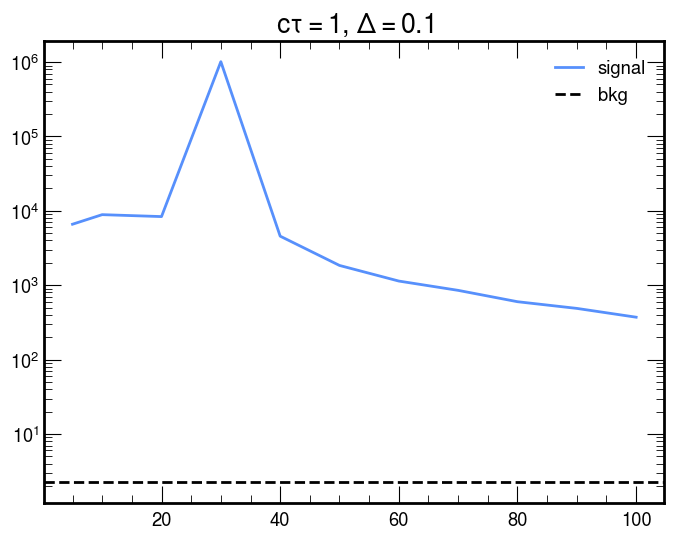

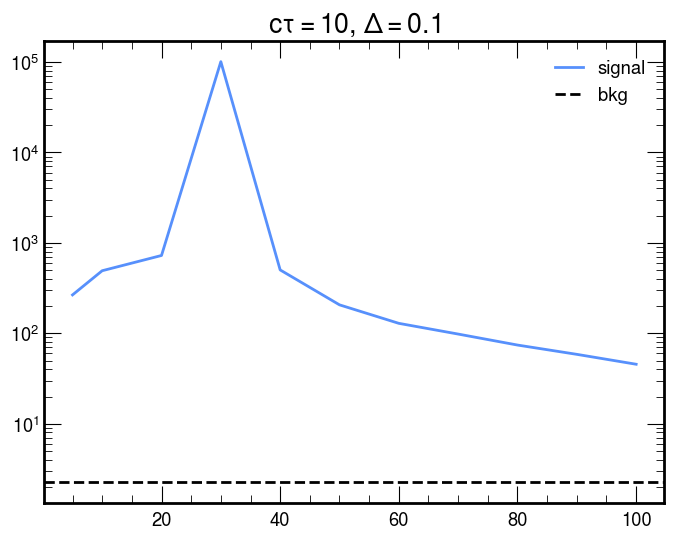

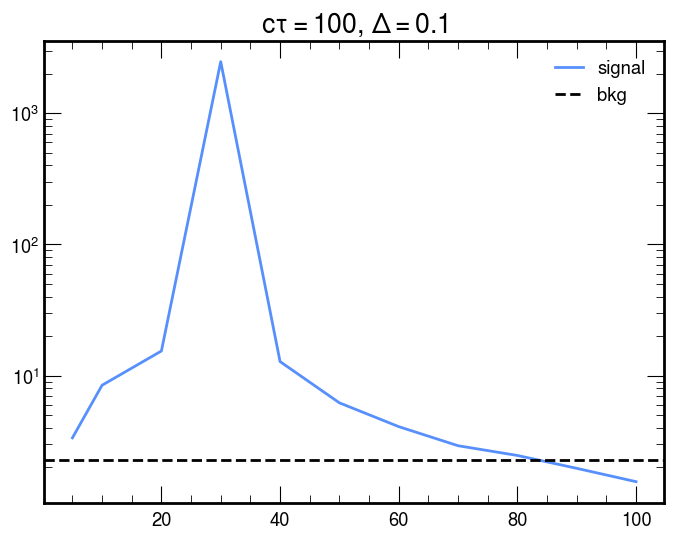

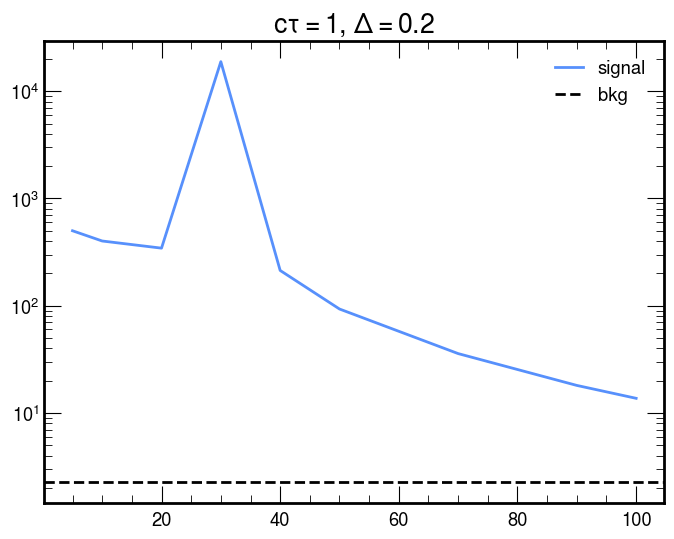

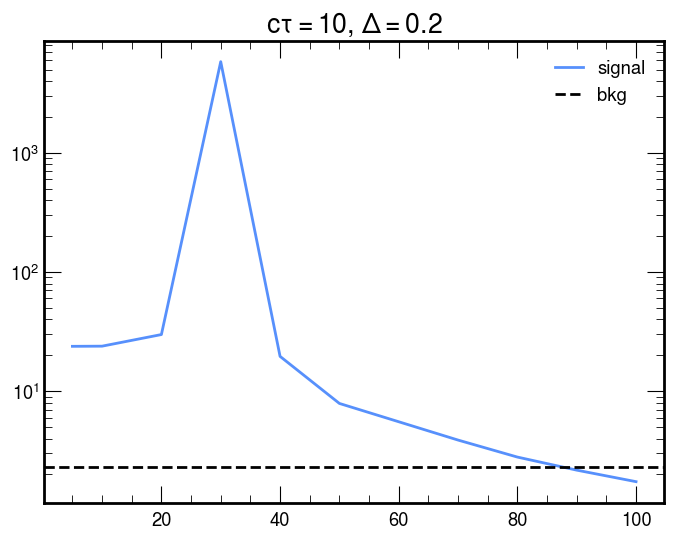

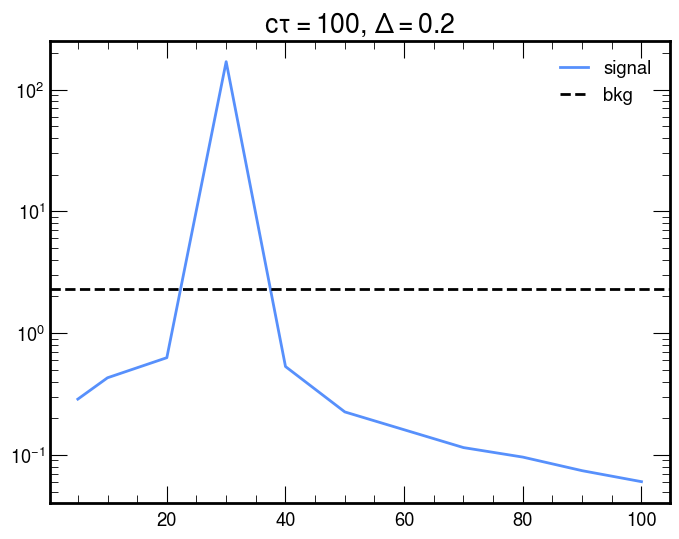

In [24]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

deltas = [0.1,0.2]
all_ctaus = [1,10,100]
for d in deltas:
    for i,ct in enumerate(all_ctaus):
        plt.figure(figsize=(8,6))
        mass1s = sorted(list(set(dfs[(dfs.ctau==ct)&(dfs.delta==d)].m1)))
        plt.title(r"$c \tau = {0}$, $\Delta = {1}$".format(ct,d))
        yields = []
        for m1 in mass1s:
            name = dfs[(dfs.ctau==ct)&(dfs.delta==d)&(dfs.m1==m1)].name[0]
            yields.append(sig_tots[name])
        plt.plot(mass1s,yields,lw=2,label='signal')
        plt.axhline(nbkg_tot,color='black',lw=2,linestyle='--',label='bkg')
        plt.yscale('log')
        plt.legend()